# 🔌 DETEKSI PENCURIAN LISTRIK PLN

## Hybrid Semi-Supervised Learning Model

**Pipeline:**
1. Load & Explore Data
2. Data Cleaning
3. Feature Engineering
4. Model Training (Isolation Forest + Random Forest + XGBoost)
5. Evaluation & Prediction
6. Export Results
7. Save Models

---

## 1. SETUP & IMPORT LIBRARIES

In [126]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
import joblib
from datetime import datetime

# Machine Learning
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("[OK] Libraries imported successfully!")

[OK] Libraries imported successfully!


## 2. LOAD DATA

In [127]:
# Load data temuan (confirmed fraud)
df_temuan = pd.read_excel('../data/Temuan 2425.xlsx')
print(f"Data Temuan: {len(df_temuan)} rows")

# Load data history pelanggan
df_history = pd.read_excel('../data/Histori Pemakaian Pelanggan.xlsx')
print(f"Data History: {len(df_history):,} rows")

# Preview
print("\n--- Data Temuan (Confirmed Fraud) ---")
display(df_temuan.head())

print("\n--- Data History (All Customers) ---")
display(df_history.head())

Data Temuan: 52 rows
Data History: 152,974 rows

--- Data Temuan (Confirmed Fraud) ---


,TGL TEMUAN,P & K,IDE,UE
0,2024-01-02,P3,AAAAAAACAwsKAgsC,AQM=
1,2024-01-19,P2,AAAAAAADAwEEBAYA,AAE=
2,2024-01-23,P3,AAAAAAMCAwMGAQcC,AAM=
3,2024-02-13,P2,AAAAAAACAwECBwUB,AQM=
4,2024-02-21,P2,AAAAAAADAwALBgQE,AAE=



--- Data History (All Customers) ---


,UE,IDE,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-02 00:00:00,2021-07-03 00:00:00,2021-08-04 00:00:00,2021-09-05 00:00:00,2021-10-06 00:00:00,2021-11-07 00:00:00,2021-12-08 00:00:00,2022-01-09 00:00:00,2022-02-21 00:00:00,2022-03-22 00:00:00,2022-04-23 00:00:00,2022-05-24 00:00:00,2022-06-25 00:00:00,2022-07-26 00:00:00,2022-08-27 00:00:00,2022-09-28 00:00:00,2022-10-28 00:00:00,2022-11-28 00:00:00,2022-12-29 00:00:00,2023-01-01 00:00:00,2023-02-02 00:00:00,2023-03-03 00:00:00,2023-04-04 00:00:00,2023-05-05 00:00:00,2023-06-06 00:00:00,2023-07-07 00:00:00,2023-08-08 00:00:00,2023-09-08 00:00:00,2023-10-09 00:00:00,2023-11-10 00:00:00,2023-12-11 00:00:00,2024-01-12 00:00:00,2024-02-12 00:00:00,2024-03-12 00:00:00,2024-04-12 00:00:00,2024-05-12 00:00:00,2024-06-12 00:00:00,2024-07-12 00:00:00,2024-08-12 00:00:00,2024-09-12 00:00:00,2024-10-12 00:00:00,2024-11-12 00:00:00,2024-12-12 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00,2025-07-01 00:00:00,2025-08-01 00:00:00,2025-09-01 00:00:00,2025-10-01 00:00:00,2025-11-01 00:00:00,2025-12-01 00:00:00,2026-01-01 00:00:00
0,AAE=,AAAAAQMCAwMDAgIB,16700.000,18656.000,17209.000,17894.000,17841.000,18339.000,18602.000,19424.000,22163.000,20539.000,23232.000,23175.000,22707.000,23730.000,23760.000,24054.000,23442.000,25028.000,23875.000,22100.000,22672.000,22142.000,23662.000,23640.000,21405.000,24169.000,23668.000,25078.000,24773.000,25542.000,27645.000,26353.000,28594.000,26798.000,27743.000,28420.000,27375.000,29328.000,28342.000,28794.000,27808.000,28827.000,28796.000,29120.000,30622.000,31477.000,33333.000,32509.000,29541.000,35692.000,32332.000,31845.000,31474.000,32683.000,32968.000,33466.000,35912.000,33882.000,35085.000
1,AAE=,AAAAAQMCAwMLBQMG,8249.000,9062.000,8765.000,8692.000,8612.000,8865.000,8668.000,8572.000,8994.000,8656.000,8819.000,8983.000,8043.000,8960.000,8688.000,9099.000,8411.000,8613.000,8336.000,8044.000,8421.000,7974.000,8287.000,8463.000,7767.000,8820.000,8585.000,8383.000,7747.000,8128.000,8253.000,8180.000,8741.000,8500.000,9236.000,10127.000,9826.000,10127.000,9752.000,9995.000,9033.000,9210.000,8542.000,7808.000,8103.000,7976.000,8316.000,7854.000,6350.000,7669.000,7305.000,7415.000,7220.000,6998.000,6649.000,7531.000,8261.000,8240.000,8695.000
2,AAE=,AAAAAAADAwMACgMC,290.000,242.000,389.000,274.000,446.000,362.000,377.000,493.000,495.000,541.000,976.000,996.000,671.000,684.000,756.000,580.000,358.000,486.000,748.000,749.000,743.000,830.000,689.000,870.000,874.000,988.000,828.000,1022.000,920.000,853.000,1193.000,1059.000,1559.000,1520.000,1189.000,1580.000,1512.000,1150.000,1150.000,1404.000,1045.000,1173.000,1700.000,1658.000,1934.000,1739.000,1498.000,1603.000,1652.000,952.000,1399.000,1417.000,1006.000,1391.000,1572.000,2019.000,1987.000,1934.000,1315.000
3,AAE=,AAAAAAADAwcABwsE,24761.000,28872.000,26161.000,26871.000,25210.000,24489.000,25837.000,25829.000,28243.000,27631.000,30118.000,25824.000,27800.000,29173.000,27332.000,27624.000,27001.000,23599.000,26937.000,26038.000,27646.000,22172.000,26943.000,27171.000,24163.000,27297.000,22016.000,26416.000,25483.000,26869.000,28030.000,27679.000,28702.000,27448.000,27935.000,25562.000,29453.000,26030.000,30113.000,28222.000,27067.000,29078.000,27529.000,28140.000,29340.000,27480.000,29820.000,29280.000,24720.000,28140.000,25680.000,28860.000,26460.000,28020.000,28260.000,27360.000,29867.000,27565.000,26544.000
4,AAE=,AAAAAAMCAwIGAAsD,17368.000,20761.000,19432.000,20701.000,16780.000,16057.000,16946.000,16435.000,15285.000,15515.000,15972.000,16412.000,14535.000,15327.000,15815.000,18297.000,14603.000,16847.000,16027.000,15353.000,16139.000,15818.000,15982.000,16218.000,14699.000,17037.000,17038.000,17484.000,16925.000,17921.000,18178.000,17475.000,18287.000,17558.000,18055.000,17788.000,16929.000,17547.000,17327.000,18573.000,17717.000,18113.000,18189.000,17782.000,18012.000,17045.000,18065.000,18458.00

## 3. DATA ANALYSIS & LABELING

In [128]:
# Get unique IDE from temuan
ide_temuan = df_temuan['IDE'].unique()
print(f"Unique IDE in temuan: {len(ide_temuan)}")

# Match with history
df_matched = df_history[df_history['IDE'].isin(ide_temuan)]
print(f"Matched records in history: {len(df_matched)}")

# Create label column
# 1 = confirmed fraud (from temuan)
# 0 = unknown (will be predicted)
df_history['label'] = df_history['IDE'].isin(ide_temuan).astype(int)

print(f"\nLabel Distribution:")
print(f"  Fraud (1):   {(df_history['label'] == 1).sum()}")
print(f"  Unknown (0): {(df_history['label'] == 0).sum():,}")

Unique IDE in temuan: 51
Matched records in history: 61

Label Distribution:
  Fraud (1):   61
  Unknown (0): 152,913


## 4. DATA CLEANING

In [130]:
# Identify date columns (monthly usage) - HANYA kolom tanggal, bukan kolom lain
# Kolom non-data: IDE, UE, label
non_date_cols = ['IDE', 'UE', 'label']
date_columns = [col for col in df_history.columns if col not in non_date_cols]

print(f"Date columns (monthly usage): {len(date_columns)}")
print(f"Kolom bulan pertama: {date_columns[0]}")
print(f"Kolom bulan terakhir: {date_columns[-1]}")

# =============================================================================
# STRATEGI TRIMMING KE PERIODE AKTIF + FILTER ELIGIBILITY
# =============================================================================
# ATURAN:
# 1. N/A di awal = belum berlangganan
# 2. N/A di akhir = sudah berhenti berlangganan -> BUANG dari prediksi
# 3. Nilai 0 di tengah periode aktif = data REAL (tidak ada pemakaian)
# 4. Minimal 12 bulan aktif untuk bisa diprediksi
# 
# Pelanggan dengan < 12 bulan aktif -> "INSUFFICIENT HISTORY"
# Pelanggan yang sudah berhenti (N/A di kolom terakhir) -> "INACTIVE/STOPPED"
# =============================================================================

MIN_ACTIVE_MONTHS = 12  # Minimal bulan untuk prediksi yang akurat

def find_active_period(row):
    """
    Mencari periode aktif pelanggan (bukan N/A).
    Return: (start_idx, end_idx) - indeks bulan pertama dan terakhir yang aktif
    """
    not_na_mask = ~pd.isna(row)
    
    if not_na_mask.sum() == 0:
        return None, None
    
    indices = np.where(not_na_mask)[0]
    start_idx = indices[0]
    end_idx = indices[-1]
    
    return start_idx, end_idx

# Simpan periode aktif untuk setiap pelanggan
print("\nMenghitung periode aktif setiap pelanggan...")
active_periods = []
for idx, row in df_history[date_columns].iterrows():
    start_idx, end_idx = find_active_period(row.values)
    if start_idx is not None:
        active_length = end_idx - start_idx + 1
    else:
        active_length = 0
    active_periods.append({
        'start_idx': start_idx,
        'end_idx': end_idx,
        'active_months': active_length
    })

df_history['active_start_idx'] = [p['start_idx'] for p in active_periods]
df_history['active_end_idx'] = [p['end_idx'] for p in active_periods]
df_history['active_months_count'] = [p['active_months'] for p in active_periods]

# Cek apakah kolom bulan terakhir adalah N/A (pelanggan sudah berhenti)
last_month_col = date_columns[-1]
df_history['is_still_active'] = ~pd.isna(df_history[last_month_col])

# Tentukan eligibility untuk prediksi
def determine_eligibility(row):
    if not row['is_still_active']:
        return 'INACTIVE_STOPPED'  # Sudah berhenti berlangganan
    elif row['active_months_count'] < MIN_ACTIVE_MONTHS:
        return 'INSUFFICIENT_HISTORY'  # Riwayat kurang dari 12 bulan
    else:
        return 'ELIGIBLE'  # Layak diprediksi

df_history['prediction_eligibility'] = df_history.apply(determine_eligibility, axis=1)

# Statistik eligibility
print(f"\n{'='*60}")
print("ELIGIBILITY FILTERING")
print('='*60)
eligibility_counts = df_history['prediction_eligibility'].value_counts()
for status, count in eligibility_counts.items():
    pct = count / len(df_history) * 100
    print(f"  {status}: {count:,} ({pct:.2f}%)")

# Statistik periode aktif (hanya untuk yang eligible)
df_eligible = df_history[df_history['prediction_eligibility'] == 'ELIGIBLE']
if len(df_eligible) > 0:
    print(f"\n[INFO] Statistik Periode Aktif (ELIGIBLE only):")
    print(f"  Min bulan aktif: {df_eligible['active_months_count'].min()}")
    print(f"  Max bulan aktif: {df_eligible['active_months_count'].max()}")
    print(f"  Rata-rata bulan aktif: {df_eligible['active_months_count'].mean():.1f}")

# Cek known fraud yang tidak eligible
known_fraud_ineligible = df_history[(df_history['label'] == 1) & (df_history['prediction_eligibility'] != 'ELIGIBLE')]
if len(known_fraud_ineligible) > 0:
    print(f"\n[WARNING] {len(known_fraud_ineligible)} known fraud TIDAK ELIGIBLE untuk prediksi!")
    print(f"  - INACTIVE_STOPPED: {(known_fraud_ineligible['prediction_eligibility'] == 'INACTIVE_STOPPED').sum()}")
    print(f"  - INSUFFICIENT_HISTORY: {(known_fraud_ineligible['prediction_eligibility'] == 'INSUFFICIENT_HISTORY').sum()}")
else:
    print(f"\n[OK] Semua {(df_history['label'] == 1).sum()} known fraud ELIGIBLE untuk prediksi")

# Simpan pelanggan yang tidak eligible ke file terpisah
df_insufficient = df_history[df_history['prediction_eligibility'] == 'INSUFFICIENT_HISTORY'][['IDE', 'UE', 'active_months_count', 'prediction_eligibility']]
df_inactive = df_history[df_history['prediction_eligibility'] == 'INACTIVE_STOPPED'][['IDE', 'UE', 'active_months_count', 'prediction_eligibility']]

print(f"\n[INFO] Pelanggan yang TIDAK akan diprediksi:")
print(f"  - INSUFFICIENT_HISTORY (< 12 bulan): {len(df_insufficient):,}")
print(f"  - INACTIVE_STOPPED (sudah berhenti): {len(df_inactive):,}")

# Konversi kolom ke numeric (N/A tetap NaN)
for col in date_columns:
    df_history[col] = pd.to_numeric(df_history[col], errors='coerce')

print(f"\n[OK] Data cleaned dengan TRIMMING + ELIGIBILITY strategy")
print(f"     Total records: {len(df_history):,}")
print(f"     ELIGIBLE untuk prediksi: {len(df_eligible):,}")
print(f"     TIDAK eligible: {len(df_history) - len(df_eligible):,}")

Date columns (monthly usage): 59
Kolom bulan pertama: 2021-03-01 00:00:00
Kolom bulan terakhir: 2026-01-01 00:00:00

Menghitung periode aktif setiap pelanggan...

ELIGIBILITY FILTERING
  ELIGIBLE: 132,738 (86.77%)
  INACTIVE_STOPPED: 14,320 (9.36%)
  INSUFFICIENT_HISTORY: 5,916 (3.87%)

[INFO] Statistik Periode Aktif (ELIGIBLE only):
  Min bulan aktif: 12
  Max bulan aktif: 59
  Rata-rata bulan aktif: 58.5

[WARNING] 20 known fraud TIDAK ELIGIBLE untuk prediksi!
  - INACTIVE_STOPPED: 0
  - INSUFFICIENT_HISTORY: 20

[INFO] Pelanggan yang TIDAK akan diprediksi:
  - INSUFFICIENT_HISTORY (< 12 bulan): 5,916
  - INACTIVE_STOPPED (sudah berhenti): 14,320

[OK] Data cleaned dengan TRIMMING + ELIGIBILITY strategy
     Total records: 152,974
     ELIGIBLE untuk prediksi: 132,738
     TIDAK eligible: 20,236


## 5. FEATURE ENGINEERING

In [131]:
# =============================================================================
# FEATURE ENGINEERING DENGAN TRIMMING KE PERIODE AKTIF
# =============================================================================
# HANYA untuk pelanggan yang ELIGIBLE (active_months >= 12 dan masih aktif)
# Pelanggan tidak eligible akan disimpan terpisah dengan status khusus
# =============================================================================

print("="*60)
print("FEATURE ENGINEERING - ONLY ELIGIBLE CUSTOMERS")
print("="*60)

# Pisahkan data berdasarkan eligibility
df_eligible = df_history[df_history['prediction_eligibility'] == 'ELIGIBLE'].copy()
df_not_eligible = df_history[df_history['prediction_eligibility'] != 'ELIGIBLE'].copy()

print(f"\nTotal pelanggan: {len(df_history):,}")
print(f"  ELIGIBLE (akan diproses): {len(df_eligible):,}")
print(f"  NOT ELIGIBLE (dilewati): {len(df_not_eligible):,}")

# Breakdown not eligible
if len(df_not_eligible) > 0:
    print(f"\n  Detail NOT ELIGIBLE:")
    for status in df_not_eligible['prediction_eligibility'].unique():
        count = (df_not_eligible['prediction_eligibility'] == status).sum()
        print(f"    - {status}: {count:,}")

def extract_active_period_data(row, date_cols):
    """
    Ekstrak data hanya dari periode aktif pelanggan.
    Return: numpy array data periode aktif (tanpa N/A)
    """
    start_idx = row['active_start_idx']
    end_idx = row['active_end_idx']
    
    if pd.isna(start_idx) or pd.isna(end_idx):
        return np.array([])
    
    start_idx = int(start_idx)
    end_idx = int(end_idx)
    
    active_data = row[date_cols].values[start_idx:end_idx+1]
    active_data = np.array([0 if pd.isna(x) else x for x in active_data], dtype=float)
    
    return active_data

print(f"\nMengekstrak fitur dari PERIODE AKTIF untuk {len(df_eligible):,} pelanggan ELIGIBLE...")
print("(Nilai 0 di tengah periode aktif = data real, bukan missing value)")

# Ekstrak fitur HANYA untuk pelanggan eligible
df_features = df_eligible.copy()

# Hitung fitur dari periode aktif
usage_means = []
usage_stds = []
usage_mins = []
usage_maxs = []
usage_ranges = []
coef_variations = []
zero_counts = []
max_drops = []
trend_slopes = []
recent_disconnects = []
inactive_months_list = []

for idx, row in df_features.iterrows():
    active_data = extract_active_period_data(row, date_columns)
    
    if len(active_data) == 0:
        usage_means.append(0)
        usage_stds.append(0)
        usage_mins.append(0)
        usage_maxs.append(0)
        usage_ranges.append(0)
        coef_variations.append(0)
        zero_counts.append(0)
        max_drops.append(0)
        trend_slopes.append(0)
        recent_disconnects.append(0)
        inactive_months_list.append(0)
        continue
    
    # Statistik dasar dari PERIODE AKTIF
    mean_val = np.mean(active_data)
    std_val = np.std(active_data)
    min_val = np.min(active_data)
    max_val = np.max(active_data)
    
    usage_means.append(mean_val)
    usage_stds.append(std_val)
    usage_mins.append(min_val)
    usage_maxs.append(max_val)
    usage_ranges.append(max_val - min_val)
    
    # Coefficient of variation
    if mean_val > 0:
        coef_variations.append(std_val / mean_val)
    else:
        coef_variations.append(0)
    
    # Zero usage count - dalam PERIODE AKTIF
    zero_counts.append((active_data == 0).sum())
    
    # Max drop between consecutive months
    if len(active_data) > 1:
        diffs = np.diff(active_data)
        max_drops.append(max(0, -np.min(diffs)))
    else:
        max_drops.append(0)
    
    # Trend slope
    if len(active_data) > 1 and np.std(active_data) > 0:
        x = np.arange(len(active_data))
        slope = np.polyfit(x, active_data, 1)[0]
        trend_slopes.append(slope)
    else:
        trend_slopes.append(0)
    
    # Recent disconnect - 3 bulan TERAKHIR
    last_3 = active_data[-3:] if len(active_data) >= 3 else active_data
    recent_disconnects.append((last_3 < 10).sum())
    
    # Inactive months
    inactive_months_list.append((active_data < 5).sum())

# Assign ke DataFrame
df_features['usage_mean'] = usage_means
df_features['usage_std'] = usage_stds
df_features['usage_min'] = usage_mins
df_features['usage_max'] = usage_maxs
df_features['usage_range'] = usage_ranges
df_features['coefficient_variation'] = coef_variations
df_features['zero_usage_count'] = zero_counts
df_features['max_drop'] = max_drops
df_features['trend_slope'] = trend_slopes
df_features['recent_disconnect'] = recent_disconnects
df_features['inactive_months'] = inactive_months_list

# UE (Unit) encoding
le_ue = LabelEncoder()
df_features['ue_encoded'] = le_ue.fit_transform(df_features['UE'].fillna('UNKNOWN'))

# UE fraud risk (historical fraud rate per UE) - HANYA dari data eligible
ue_fraud_rate = df_features.groupby('UE')['label'].mean()
df_features['ue_fraud_risk'] = df_features['UE'].map(ue_fraud_rate).fillna(0)

# Define feature columns
feature_cols = [
    'usage_mean', 'usage_std', 'usage_min', 'usage_max', 'usage_range',
    'coefficient_variation', 'zero_usage_count', 'max_drop', 'trend_slope',
    'recent_disconnect', 'inactive_months', 'ue_encoded', 'ue_fraud_risk'
]

print(f"\n[OK] Created {len(feature_cols)} features dari PERIODE AKTIF:")
for f in feature_cols:
    print(f"  - {f}")

# Statistik zero_usage_count (penting untuk deteksi fraud)
print(f"\n[INFO] Statistik Zero Usage (dalam periode aktif, ELIGIBLE only):")
print(f"  Pelanggan dengan 0 bulan zero usage: {(df_features['zero_usage_count'] == 0).sum():,}")
print(f"  Pelanggan dengan >= 3 bulan zero usage: {(df_features['zero_usage_count'] >= 3).sum():,}")
print(f"  Pelanggan dengan >= 6 bulan zero usage: {(df_features['zero_usage_count'] >= 6).sum():,}")
print(f"  Max zero usage count: {df_features['zero_usage_count'].max()}")

# Perbandingan known fraud vs unknown (ELIGIBLE only)
n_fraud_eligible = (df_features['label'] == 1).sum()
n_unknown_eligible = (df_features['label'] == 0).sum()
fraud_zero_mean = df_features[df_features['label'] == 1]['zero_usage_count'].mean() if n_fraud_eligible > 0 else 0
unknown_zero_mean = df_features[df_features['label'] == 0]['zero_usage_count'].mean() if n_unknown_eligible > 0 else 0

print(f"\n[INFO] Rata-rata Zero Usage Count (ELIGIBLE only):")
print(f"  Known Fraud ({n_fraud_eligible}): {fraud_zero_mean:.2f} bulan")
print(f"  Unknown ({n_unknown_eligible:,}): {unknown_zero_mean:.2f} bulan")

# Simpan info pelanggan tidak eligible untuk export nanti
print(f"\n[INFO] Pelanggan NOT ELIGIBLE akan diberi status khusus di export:")
print(f"  - INSUFFICIENT_HISTORY: Riwayat < 12 bulan - belum bisa dievaluasi")
print(f"  - INACTIVE_STOPPED: Sudah berhenti berlangganan - tidak perlu dievaluasi")

FEATURE ENGINEERING - ONLY ELIGIBLE CUSTOMERS

Total pelanggan: 152,974
  ELIGIBLE (akan diproses): 132,738
  NOT ELIGIBLE (dilewati): 20,236

  Detail NOT ELIGIBLE:
    - INACTIVE_STOPPED: 14,320
    - INSUFFICIENT_HISTORY: 5,916

Mengekstrak fitur dari PERIODE AKTIF untuk 132,738 pelanggan ELIGIBLE...
(Nilai 0 di tengah periode aktif = data real, bukan missing value)

[OK] Created 13 features dari PERIODE AKTIF:
  - usage_mean
  - usage_std
  - usage_min
  - usage_max
  - usage_range
  - coefficient_variation
  - zero_usage_count
  - max_drop
  - trend_slope
  - recent_disconnect
  - inactive_months
  - ue_encoded
  - ue_fraud_risk

[INFO] Statistik Zero Usage (dalam periode aktif, ELIGIBLE only):
  Pelanggan dengan 0 bulan zero usage: 112,726
  Pelanggan dengan >= 3 bulan zero usage: 11,474
  Pelanggan dengan >= 6 bulan zero usage: 8,152
  Max zero usage count: 59

[INFO] Rata-rata Zero Usage Count (ELIGIBLE only):
  Known Fraud (41): 3.54 bulan
  Unknown (132,697): 1.59 bulan

[INF

In [158]:
# =============================================================================
# TEMPORAL FEATURES - MENDETEKSI PERUBAHAN POLA WAKTU
# =============================================================================
# Fitur ini membandingkan pola penggunaan di AWAL vs AKHIR periode
# untuk mendeteksi transisi dari "normal" ke "fraud"
# 
# PENTING: Data temuan fraud di 2024-2025, tapi history dari 2021
# Pencuri mungkin normal di 2021-2023, lalu mulai mencuri 2024
# =============================================================================

print("="*60)
print("TEMPORAL FEATURES - DETEKSI PERUBAHAN POLA")
print("="*60)

def extract_temporal_features(row, date_cols):
    """
    Ekstrak fitur temporal untuk mendeteksi perubahan pola.
    Membandingkan periode awal vs akhir.
    """
    start_idx = row['active_start_idx']
    end_idx = row['active_end_idx']
    
    if pd.isna(start_idx) or pd.isna(end_idx):
        return {
            'first_year_mean': 0, 'last_year_mean': 0,
            'year_change_abs': 0, 'year_change_pct': 0,
            'first_year_zero': 0, 'last_year_zero': 0, 'zero_increase': 0,
            'stability_first': 0, 'stability_last': 0, 'stability_change': 0,
            'max_window_drop': 0, 'volatility_change': 0,
            'trend_break_score': 0, 'recent_anomaly_score': 0
        }
    
    start_idx = int(start_idx)
    end_idx = int(end_idx)
    
    active_data = row[date_cols].values[start_idx:end_idx+1]
    active_data = np.array([0 if pd.isna(x) else x for x in active_data], dtype=float)
    
    if len(active_data) < 12:
        # Jika kurang dari 12 bulan, return nilai default
        return {
            'first_year_mean': np.mean(active_data) if len(active_data) > 0 else 0,
            'last_year_mean': np.mean(active_data) if len(active_data) > 0 else 0,
            'year_change_abs': 0, 'year_change_pct': 0,
            'first_year_zero': (active_data == 0).sum() if len(active_data) > 0 else 0,
            'last_year_zero': (active_data == 0).sum() if len(active_data) > 0 else 0,
            'zero_increase': 0,
            'stability_first': np.std(active_data) if len(active_data) > 1 else 0,
            'stability_last': np.std(active_data) if len(active_data) > 1 else 0,
            'stability_change': 0,
            'max_window_drop': 0, 'volatility_change': 0,
            'trend_break_score': 0, 'recent_anomaly_score': 0
        }
    
    # ========== STRATEGI 1: Perbandingan Tahun Pertama vs Tahun Terakhir ==========
    first_year = active_data[:12]  # 12 bulan pertama
    last_year = active_data[-12:]  # 12 bulan terakhir
    
    first_year_mean = np.mean(first_year)
    last_year_mean = np.mean(last_year)
    
    # Perubahan absolut dan persentase
    year_change_abs = last_year_mean - first_year_mean
    year_change_pct = 0
    if first_year_mean > 10:  # Threshold minimum untuk perbandingan valid
        year_change_pct = ((last_year_mean - first_year_mean) / first_year_mean) * 100
    
    # Zero usage comparison
    first_year_zero = (first_year == 0).sum()
    last_year_zero = (last_year == 0).sum()
    zero_increase = last_year_zero - first_year_zero
    
    # Stability comparison (std deviation)
    stability_first = np.std(first_year)
    stability_last = np.std(last_year)
    stability_change = stability_last - stability_first
    
    # ========== STRATEGI 2: Sliding Window untuk Deteksi Penurunan Drastis ==========
    window_size = 6  # 6 bulan per window
    if len(active_data) >= window_size * 2:
        windows = [active_data[i:i+window_size] for i in range(0, len(active_data) - window_size + 1, window_size)]
        window_means = [np.mean(w) for w in windows]
        
        # Max drop between consecutive windows
        max_window_drop = 0
        for i in range(1, len(window_means)):
            drop = window_means[i-1] - window_means[i]
            if drop > max_window_drop:
                max_window_drop = drop
        
        # Volatility change (std between windows)
        if len(window_means) >= 2:
            first_half_std = np.std(window_means[:len(window_means)//2])
            second_half_std = np.std(window_means[len(window_means)//2:])
            volatility_change = second_half_std - first_half_std
        else:
            volatility_change = 0
    else:
        max_window_drop = 0
        volatility_change = 0
    
    # ========== STRATEGI 3: Trend Break Detection ==========
    # Deteksi titik perubahan trend
    if len(active_data) >= 24:
        half_point = len(active_data) // 2
        first_half = active_data[:half_point]
        second_half = active_data[half_point:]
        
        # Calculate trend for each half
        x1 = np.arange(len(first_half))
        x2 = np.arange(len(second_half))
        
        if np.std(first_half) > 0 and np.std(second_half) > 0:
            trend1 = np.polyfit(x1, first_half, 1)[0]
            trend2 = np.polyfit(x2, second_half, 1)[0]
            # Trend break = difference in slopes (positive means second half declining faster)
            trend_break_score = trend1 - trend2
        else:
            trend_break_score = 0
    else:
        trend_break_score = 0
    
    # ========== STRATEGI 4: Recent Anomaly Score ==========
    # Bandingkan 6 bulan terakhir dengan keseluruhan
    recent_6 = active_data[-6:]
    overall_mean = np.mean(active_data)
    overall_std = np.std(active_data)
    
    if overall_std > 0:
        # Z-score of recent period relative to overall
        recent_anomaly_score = (np.mean(recent_6) - overall_mean) / overall_std
    else:
        recent_anomaly_score = 0
    
    return {
        'first_year_mean': first_year_mean,
        'last_year_mean': last_year_mean,
        'year_change_abs': year_change_abs,
        'year_change_pct': year_change_pct,
        'first_year_zero': first_year_zero,
        'last_year_zero': last_year_zero,
        'zero_increase': zero_increase,
        'stability_first': stability_first,
        'stability_last': stability_last,
        'stability_change': stability_change,
        'max_window_drop': max_window_drop,
        'volatility_change': volatility_change,
        'trend_break_score': trend_break_score,
        'recent_anomaly_score': recent_anomaly_score
    }

print("\nMengekstrak TEMPORAL FEATURES...")
print("  - Membandingkan 12 bulan pertama vs 12 bulan terakhir")
print("  - Mendeteksi penurunan drastis dengan sliding window")
print("  - Mendeteksi perubahan trend (trend break)")
print("  - Menghitung anomaly score periode terbaru")

# Ekstrak temporal features
temporal_features_list = []
for idx, row in df_features.iterrows():
    temporal_features_list.append(extract_temporal_features(row, date_columns))

# Convert to DataFrame dan gabungkan
df_temporal = pd.DataFrame(temporal_features_list, index=df_features.index)
for col in df_temporal.columns:
    df_features[col] = df_temporal[col].values

# Update feature_cols dengan fitur temporal baru
temporal_feature_cols = [
    'first_year_mean', 'last_year_mean', 
    'year_change_abs', 'year_change_pct',
    'first_year_zero', 'last_year_zero', 'zero_increase',
    'stability_first', 'stability_last', 'stability_change',
    'max_window_drop', 'volatility_change',
    'trend_break_score', 'recent_anomaly_score'
]

# Gabungkan dengan feature_cols yang ada
feature_cols = feature_cols + temporal_feature_cols

print(f"\n[OK] Ditambahkan {len(temporal_feature_cols)} TEMPORAL FEATURES:")
for f in temporal_feature_cols:
    print(f"  - {f}")

print(f"\n[TOTAL] Sekarang ada {len(feature_cols)} fitur untuk training")

# =================== ANALISIS TEMPORAL FEATURES ===================
print("\n" + "="*60)
print("ANALISIS TEMPORAL FEATURES - Known Fraud vs Unknown")
print("="*60)

fraud_mask = df_features['label'] == 1
n_fraud = fraud_mask.sum()
n_unknown = (~fraud_mask).sum()

print(f"\nKnown Fraud: {n_fraud} | Unknown: {n_unknown:,}")
print("-"*60)

# Key temporal features comparison
key_temporal = ['year_change_pct', 'zero_increase', 'max_window_drop', 'trend_break_score', 'recent_anomaly_score']

for feat in key_temporal:
    fraud_val = df_features.loc[fraud_mask, feat].mean()
    unknown_val = df_features.loc[~fraud_mask, feat].mean()
    diff = fraud_val - unknown_val
    
    # Determine direction
    if abs(diff) > 0.1:
        direction = "↑ FRAUD LEBIH TINGGI" if diff > 0 else "↓ FRAUD LEBIH RENDAH"
    else:
        direction = "≈ MIRIP"
    
    print(f"\n{feat}:")
    print(f"  Known Fraud: {fraud_val:,.2f}")
    print(f"  Unknown:     {unknown_val:,.2f}")
    print(f"  Perbedaan:   {diff:+,.2f} ({direction})")

# Highlight most important temporal feature
print("\n" + "="*60)
print("FITUR TEMPORAL PALING PENTING:")
print("-"*60)
print("• year_change_pct: Perubahan persentase usage antara tahun pertama dan terakhir")
print("  → Fraud yang mencuri di 2024 akan menunjukkan PENURUNAN dari baseline 2021")
print("• zero_increase: Peningkatan jumlah bulan dengan zero usage")
print("  → Fraud cenderung punya lebih banyak zero usage di akhir periode")
print("• max_window_drop: Penurunan drastis antar periode 6-bulanan")
print("  → Mendeteksi kapan pola berubah secara tiba-tiba")
print("="*60)

TEMPORAL FEATURES - DETEKSI PERUBAHAN POLA

Mengekstrak TEMPORAL FEATURES...
  - Membandingkan 12 bulan pertama vs 12 bulan terakhir
  - Mendeteksi penurunan drastis dengan sliding window
  - Mendeteksi perubahan trend (trend break)
  - Menghitung anomaly score periode terbaru

[OK] Ditambahkan 14 TEMPORAL FEATURES:
  - first_year_mean
  - last_year_mean
  - year_change_abs
  - year_change_pct
  - first_year_zero
  - last_year_zero
  - zero_increase
  - stability_first
  - stability_last
  - stability_change
  - max_window_drop
  - volatility_change
  - trend_break_score
  - recent_anomaly_score

[TOTAL] Sekarang ada 27 fitur untuk training

ANALISIS TEMPORAL FEATURES - Known Fraud vs Unknown

Known Fraud: 41 | Unknown: 132,697
------------------------------------------------------------

year_change_pct:
  Known Fraud: 4.28
  Unknown:     30.95
  Perbedaan:   -26.67 (↓ FRAUD LEBIH RENDAH)

zero_increase:
  Known Fraud: 0.27
  Unknown:     0.02
  Perbedaan:   +0.25 (↑ FRAUD LEBIH TINGG

---

## 6. MODEL TRAINING

### Pipeline:
1. **Isolation Forest** → Detect anomaly patterns dari seluruh data
2. **Pseudo-labeling** → Sample "likely normal" dari data yang tidak anomaly
3. **SMOTE** → Balance training data
4. **Random Forest + XGBoost** → Train supervised models
5. **Ensemble** → Combine predictions

### 6.1 ISOLATION FOREST - Detect Anomaly

In [159]:
print("="*60)
print("STEP 1: ISOLATION FOREST")
print("="*60)

# Prepare features
X_all = df_features[feature_cols].values
print(f"Total data: {len(X_all):,} pelanggan")

# Scale features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# Train Isolation Forest
print("\nTraining Isolation Forest...")
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # Expect ~1% anomaly
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_all_scaled)

# Predict: 1 = normal, -1 = anomaly
iso_predictions = iso_forest.predict(X_all_scaled)
df_features['iso_prediction'] = iso_predictions

n_normal = (iso_predictions == 1).sum()
n_anomaly = (iso_predictions == -1).sum()

print(f"\nResults:")
print(f"  Likely Normal: {n_normal:,} ({n_normal/len(X_all)*100:.1f}%)")
print(f"  Anomaly:       {n_anomaly:,} ({n_anomaly/len(X_all)*100:.1f}%)")

# Validate on known fraud
known_fraud_detected = df_features[(df_features['label'] == 1) & (df_features['iso_prediction'] == -1)]
print(f"\nValidation: {len(known_fraud_detected)}/{(df_features['label'] == 1).sum()} known fraud detected as anomaly")

STEP 1: ISOLATION FOREST
Total data: 132,738 pelanggan

Training Isolation Forest...

Results:
  Likely Normal: 131,410 (99.0%)
  Anomaly:       1,328 (1.0%)

Validation: 0/41 known fraud detected as anomaly


### 6.2 PSEUDO-LABELING - Create Training Data

In [160]:
print("="*60)
print("STEP 2: PSEUDO-LABELING")
print("="*60)

# Get "likely normal" (not anomaly, not known fraud)
likely_normal_mask = (df_features['iso_prediction'] == 1) & (df_features['label'] != 1)
df_likely_normal = df_features[likely_normal_mask]
print(f"Likely Normal pool: {len(df_likely_normal):,}")

# Sample for training (pseudo-normal)
n_sample = min(5000, len(df_likely_normal))
df_pseudo_normal = df_likely_normal.sample(n=n_sample, random_state=42)
df_pseudo_normal = df_pseudo_normal.copy()
df_pseudo_normal['pseudo_label'] = 0
print(f"Sampled pseudo-normal: {n_sample}")

# Get confirmed fraud
df_confirmed_fraud = df_features[df_features['label'] == 1].copy()
df_confirmed_fraud['pseudo_label'] = 1
print(f"Confirmed fraud: {len(df_confirmed_fraud)}")

# Combine training data
df_train = pd.concat([df_pseudo_normal, df_confirmed_fraud], ignore_index=True)
X_train = df_train[feature_cols].values
y_train = df_train['pseudo_label'].values

print(f"\nTraining Dataset:")
print(f"  Normal: {(y_train == 0).sum()}")
print(f"  Fraud:  {(y_train == 1).sum()}")
print(f"  Ratio:  1:{(y_train == 0).sum() // max(1, (y_train == 1).sum())}")

STEP 2: PSEUDO-LABELING
Likely Normal pool: 131,369
Sampled pseudo-normal: 5000
Confirmed fraud: 41

Training Dataset:
  Normal: 5000
  Fraud:  41
  Ratio:  1:121


### 6.3 SMOTE - Balance Training Data

In [161]:
print("="*60)
print("STEP 3: SMOTE BALANCING")
print("="*60)

# Scale training data
X_train_scaled = scaler.transform(X_train)

# Apply SMOTE
k_neighbors = min(5, (y_train == 1).sum() - 1)
smote = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: Normal={(y_train == 0).sum()}, Fraud={(y_train == 1).sum()}")
print(f"After SMOTE:  Normal={(y_train_balanced == 0).sum()}, Fraud={(y_train_balanced == 1).sum()}")
print("[OK] Data balanced 1:1")

STEP 3: SMOTE BALANCING
Before SMOTE: Normal=5000, Fraud=41
After SMOTE:  Normal=5000, Fraud=5000
[OK] Data balanced 1:1


### 6.4 TRAIN MODELS - Random Forest & XGBoost

In [162]:
print("="*60)
print("STEP 4: TRAIN MODELS")
print("="*60)

# Random Forest
print("\nTraining Random Forest (300 trees)...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
print("[OK] Random Forest trained!")

# XGBoost
print("\nTraining XGBoost (200 estimators)...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train_balanced, y_train_balanced)
print("[OK] XGBoost trained!")

STEP 4: TRAIN MODELS

Training Random Forest (300 trees)...
[OK] Random Forest trained!

Training XGBoost (200 estimators)...
[OK] XGBoost trained!


### 6.5 PREDICT - Ensemble Averaging

In [163]:
print("="*60)
print("STEP 5: PREDICTION")
print("="*60)

# Predict probability
print("\nGenerating predictions on all data...")
rf_proba = rf_model.predict_proba(X_all_scaled)[:, 1]
xgb_proba = xgb_model.predict_proba(X_all_scaled)[:, 1]

# Ensemble: average
ensemble_proba = (rf_proba + xgb_proba) / 2

# Add to dataframe
df_features['rf_fraud_prob'] = rf_proba
df_features['xgb_fraud_prob'] = xgb_proba
df_features['ensemble_fraud_prob'] = ensemble_proba
df_features['prediction'] = (ensemble_proba >= 0.5).astype(int)

print("[OK] Predictions complete!")

# Summary
pred_fraud = (df_features['prediction'] == 1).sum()
pred_normal = (df_features['prediction'] == 0).sum()
print(f"\nPrediction Summary:")
print(f"  Predicted Fraud:  {pred_fraud:,} ({pred_fraud/len(df_features)*100:.2f}%)")
print(f"  Predicted Normal: {pred_normal:,} ({pred_normal/len(df_features)*100:.2f}%)")

STEP 5: PREDICTION

Generating predictions on all data...
[OK] Predictions complete!

Prediction Summary:
  Predicted Fraud:  1,747 (1.32%)
  Predicted Normal: 130,991 (98.68%)


---

## 7. MODEL EVALUATION

In [164]:
print("="*60)
print("MODEL EVALUATION")
print("="*60)

# Evaluate on known fraud
known_fraud = df_features[df_features['label'] == 1]
detected = (known_fraud['prediction'] == 1).sum()
total_fraud = len(known_fraud)
recall = detected / total_fraud

print(f"\nKnown Fraud Detection:")
print(f"  Detected: {detected}/{total_fraud}")
print(f"  Recall:   {recall*100:.1f}%")

# Probability distribution
print(f"\nFraud Probability Distribution (known fraud):")
print(f"  > 0.8:    {(known_fraud['ensemble_fraud_prob'] > 0.8).sum()}")
print(f"  0.5-0.8:  {((known_fraud['ensemble_fraud_prob'] >= 0.5) & (known_fraud['ensemble_fraud_prob'] <= 0.8)).sum()}")
print(f"  < 0.5:    {(known_fraud['ensemble_fraud_prob'] < 0.5).sum()} (missed)")

MODEL EVALUATION

Known Fraud Detection:
  Detected: 40/41
  Recall:   97.6%

Fraud Probability Distribution (known fraud):
  > 0.8:    39
  0.5-0.8:  1
  < 0.5:    1 (missed)


### 7.1 Detailed Metrics & Model Comparison

In [165]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

print("="*70)
print("DETAILED METRICS & MODEL COMPARISON")
print("="*70)

# Prepare true labels (only for known fraud)
y_true = df_features['label'].values
y_pred = df_features['prediction'].values

# Get predictions from each model
rf_pred = (df_features['rf_fraud_prob'] >= 0.5).astype(int).values
xgb_pred = (df_features['xgb_fraud_prob'] >= 0.5).astype(int).values
ensemble_pred = y_pred

# ============================================
# 1. METRICS PADA KNOWN FRAUD (61 records)
# ============================================
print("\n" + "="*70)
print("1. EVALUATION ON KNOWN FRAUD (61 records)")
print("="*70)

known_mask = (y_true == 1)
y_true_known = y_true[known_mask]

# Random Forest
rf_known = rf_pred[known_mask]
rf_recall = recall_score(y_true_known, rf_known)
rf_detected = rf_known.sum()

# XGBoost
xgb_known = xgb_pred[known_mask]
xgb_recall = recall_score(y_true_known, xgb_known)
xgb_detected = xgb_known.sum()

# Ensemble
ensemble_known = ensemble_pred[known_mask]
ensemble_recall = recall_score(y_true_known, ensemble_known)
ensemble_detected = ensemble_known.sum()

print("\nRECALL COMPARISON (on 61 known fraud):")
print(f"  Random Forest : {rf_detected}/61 → {rf_recall*100:.1f}%")
print(f"  XGBoost       : {xgb_detected}/61 → {xgb_recall*100:.1f}%")
print(f"  Ensemble      : {ensemble_detected}/61 → {ensemble_recall*100:.1f}%")

# ============================================
# 2. METRICS PADA TRAINING DATA (10,000 records balanced)
# ============================================
print("\n" + "="*70)
print("2. EVALUATION ON TRAINING DATA (10,000 records)")
print("="*70)

# Prediksi pada training data
rf_train_proba = rf_model.predict_proba(X_train_balanced)[:, 1]
xgb_train_proba = xgb_model.predict_proba(X_train_balanced)[:, 1]
ensemble_train_proba = (rf_train_proba + xgb_train_proba) / 2

rf_train_pred = (rf_train_proba >= 0.5).astype(int)
xgb_train_pred = (xgb_train_proba >= 0.5).astype(int)
ensemble_train_pred = (ensemble_train_proba >= 0.5).astype(int)

# Metrics untuk Random Forest
print("\n[RF] RANDOM FOREST:")
print(f"  Accuracy  : {accuracy_score(y_train_balanced, rf_train_pred)*100:.2f}%")
print(f"  Precision : {precision_score(y_train_balanced, rf_train_pred)*100:.2f}%")
print(f"  Recall    : {recall_score(y_train_balanced, rf_train_pred)*100:.2f}%")
print(f"  F1-Score  : {f1_score(y_train_balanced, rf_train_pred)*100:.2f}%")

# Metrics untuk XGBoost
print("\n[XGB] XGBOOST:")
print(f"  Accuracy  : {accuracy_score(y_train_balanced, xgb_train_pred)*100:.2f}%")
print(f"  Precision : {precision_score(y_train_balanced, xgb_train_pred)*100:.2f}%")
print(f"  Recall    : {recall_score(y_train_balanced, xgb_train_pred)*100:.2f}%")
print(f"  F1-Score  : {f1_score(y_train_balanced, xgb_train_pred)*100:.2f}%")

# Metrics untuk Ensemble
print("\n[ENS] ENSEMBLE (RF + XGBoost Average):")
print(f"  Accuracy  : {accuracy_score(y_train_balanced, ensemble_train_pred)*100:.2f}%")
print(f"  Precision : {precision_score(y_train_balanced, ensemble_train_pred)*100:.2f}%")
print(f"  Recall    : {recall_score(y_train_balanced, ensemble_train_pred)*100:.2f}%")
print(f"  F1-Score  : {f1_score(y_train_balanced, ensemble_train_pred)*100:.2f}%")

# ============================================
# 3. CONFUSION MATRIX
# ============================================
print("\n" + "="*70)
print("3. CONFUSION MATRIX (Training Data)")
print("="*70)

cm_rf = confusion_matrix(y_train_balanced, rf_train_pred)
cm_xgb = confusion_matrix(y_train_balanced, xgb_train_pred)
cm_ensemble = confusion_matrix(y_train_balanced, ensemble_train_pred)

print("\n[RF] RANDOM FOREST:")
print(f"  True Negative : {cm_rf[0,0]:>5,}  |  False Positive: {cm_rf[0,1]:>5,}")
print(f"  False Negative: {cm_rf[1,0]:>5,}  |  True Positive : {cm_rf[1,1]:>5,}")

print("\n[XGB] XGBOOST:")
print(f"  True Negative : {cm_xgb[0,0]:>5,}  |  False Positive: {cm_xgb[0,1]:>5,}")
print(f"  False Negative: {cm_xgb[1,0]:>5,}  |  True Positive : {cm_xgb[1,1]:>5,}")

print("\n[ENS] ENSEMBLE:")
print(f"  True Negative : {cm_ensemble[0,0]:>5,}  |  False Positive: {cm_ensemble[0,1]:>5,}")
print(f"  False Negative: {cm_ensemble[1,0]:>5,}  |  True Positive : {cm_ensemble[1,1]:>5,}")

# ============================================
# 4. MODEL AGREEMENT
# ============================================
print("\n" + "="*70)
print("4. MODEL AGREEMENT")
print("="*70)

# Agreement pada training data
agreement_train = (rf_train_pred == xgb_train_pred).sum()
agreement_pct_train = agreement_train / len(y_train_balanced) * 100

# Agreement pada known fraud
agreement_known = (rf_known == xgb_known).sum()
agreement_pct_known = agreement_known / len(y_true_known) * 100

print(f"\nRF vs XGBoost Agreement:")
print(f"  Training Data : {agreement_train:>6,}/{len(y_train_balanced):>6,} ({agreement_pct_train:.1f}%)")
print(f"  Known Fraud   : {agreement_known:>6,}/{len(y_true_known):>6,} ({agreement_pct_known:.1f}%)")

# ============================================
# 5. SUMMARY TABLE
# ============================================
print("\n" + "="*70)
print("5. SUMMARY TABLE")
print("="*70)

summary_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Ensemble'],
    'Accuracy': [
        f"{accuracy_score(y_train_balanced, rf_train_pred)*100:.2f}%",
        f"{accuracy_score(y_train_balanced, xgb_train_pred)*100:.2f}%",
        f"{accuracy_score(y_train_balanced, ensemble_train_pred)*100:.2f}%"
    ],
    'Precision': [
        f"{precision_score(y_train_balanced, rf_train_pred)*100:.2f}%",
        f"{precision_score(y_train_balanced, xgb_train_pred)*100:.2f}%",
        f"{precision_score(y_train_balanced, ensemble_train_pred)*100:.2f}%"
    ],
    'Recall': [
        f"{recall_score(y_train_balanced, rf_train_pred)*100:.2f}%",
        f"{recall_score(y_train_balanced, xgb_train_pred)*100:.2f}%",
        f"{recall_score(y_train_balanced, ensemble_train_pred)*100:.2f}%"
    ],
    'F1-Score': [
        f"{f1_score(y_train_balanced, rf_train_pred)*100:.2f}%",
        f"{f1_score(y_train_balanced, xgb_train_pred)*100:.2f}%",
        f"{f1_score(y_train_balanced, ensemble_train_pred)*100:.2f}%"
    ],
    'Known Fraud Recall': [
        f"{rf_recall*100:.1f}%",
        f"{xgb_recall*100:.1f}%",
        f"{ensemble_recall*100:.1f}%"
    ]
})

print("\n" + summary_df.to_string(index=False))

print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)

DETAILED METRICS & MODEL COMPARISON

1. EVALUATION ON KNOWN FRAUD (61 records)

RECALL COMPARISON (on 61 known fraud):
  Random Forest : 40/61 → 97.6%
  XGBoost       : 41/61 → 100.0%
  Ensemble      : 40/61 → 97.6%

2. EVALUATION ON TRAINING DATA (10,000 records)

[RF] RANDOM FOREST:
  Accuracy  : 98.85%
  Precision : 97.77%
  Recall    : 99.98%
  F1-Score  : 98.86%

[XGB] XGBOOST:
  Accuracy  : 100.00%
  Precision : 100.00%
  Recall    : 100.00%
  F1-Score  : 100.00%

[ENS] ENSEMBLE (RF + XGBoost Average):
  Accuracy  : 99.99%
  Precision : 100.00%
  Recall    : 99.98%
  F1-Score  : 99.99%

3. CONFUSION MATRIX (Training Data)

[RF] RANDOM FOREST:
  True Negative : 4,886  |  False Positive:   114
  False Negative:     1  |  True Positive : 4,999

[XGB] XGBOOST:
  True Negative : 5,000  |  False Positive:     0
  False Negative:     0  |  True Positive : 5,000

[ENS] ENSEMBLE:
  True Negative : 5,000  |  False Positive:     0
  False Negative:     1  |  True Positive : 4,999

4. MODEL 

---

## 8. SUSPECT RANKING

In [139]:
print("="*60)
print("SUSPECT RANKING")
print("="*60)

# Exclude known fraud
df_suspects = df_features[df_features['label'] != 1].copy()
df_suspects = df_suspects.sort_values('ensemble_fraud_prob', ascending=False)

# Create priority tiers
df_suspects['priority'] = pd.cut(
    df_suspects['ensemble_fraud_prob'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
)

# Count by tier
tier_counts = df_suspects['priority'].value_counts()
print("\nPriority Distribution:")
for tier in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']:
    count = tier_counts.get(tier, 0)
    pct = count / len(df_suspects) * 100
    print(f"  {tier:10s}: {count:>7,} ({pct:>5.2f}%)")

# Top 20 suspects
print("\n" + "-"*60)
print("TOP 20 SUSPECTS:")
print("-"*60)
display(df_suspects.head(20)[['IDE', 'UE', 'ensemble_fraud_prob', 'priority']])

SUSPECT RANKING

Priority Distribution:
  CRITICAL  :   2,428 ( 1.83%)
  HIGH      :   2,683 ( 2.02%)
  MEDIUM    :   5,028 ( 3.79%)
  LOW       : 122,558 (92.36%)

------------------------------------------------------------
TOP 20 SUSPECTS:
------------------------------------------------------------


,IDE,UE,ensemble_fraud_prob,priority
142646,AAAAAAACAwUDAgYF,AQM=,0.987,CRITICAL
142121,AAAAAAACAwMBAQoE,AQM=,0.985,CRITICAL
135547,AAAAAAADAgUJCQMF,AwI=,0.985,CRITICAL
108306,AAAAAAACAwQEBgcG,AAM=,0.984,CRITICAL
132505,AAAAAAACAwEJBAIH,AwI=,0.983,CRITICAL
147481,AAAAAAACAwcEBAIA,AQM=,0.983,CRITICAL
7623,AAAAAQMCAwMABAML,AAE=,0.983,CRITICAL
126937,AAAAAAECAwADAgYL,AwI=,0.979,CRITICAL
110943,AAAAAAACAwcAAwEA,AAM=,0.976,CRITICAL
3661,AAAAAAACAwIHBgIA,AAE=,0.975,CRITICAL


---

## 9. VISUALIZATION

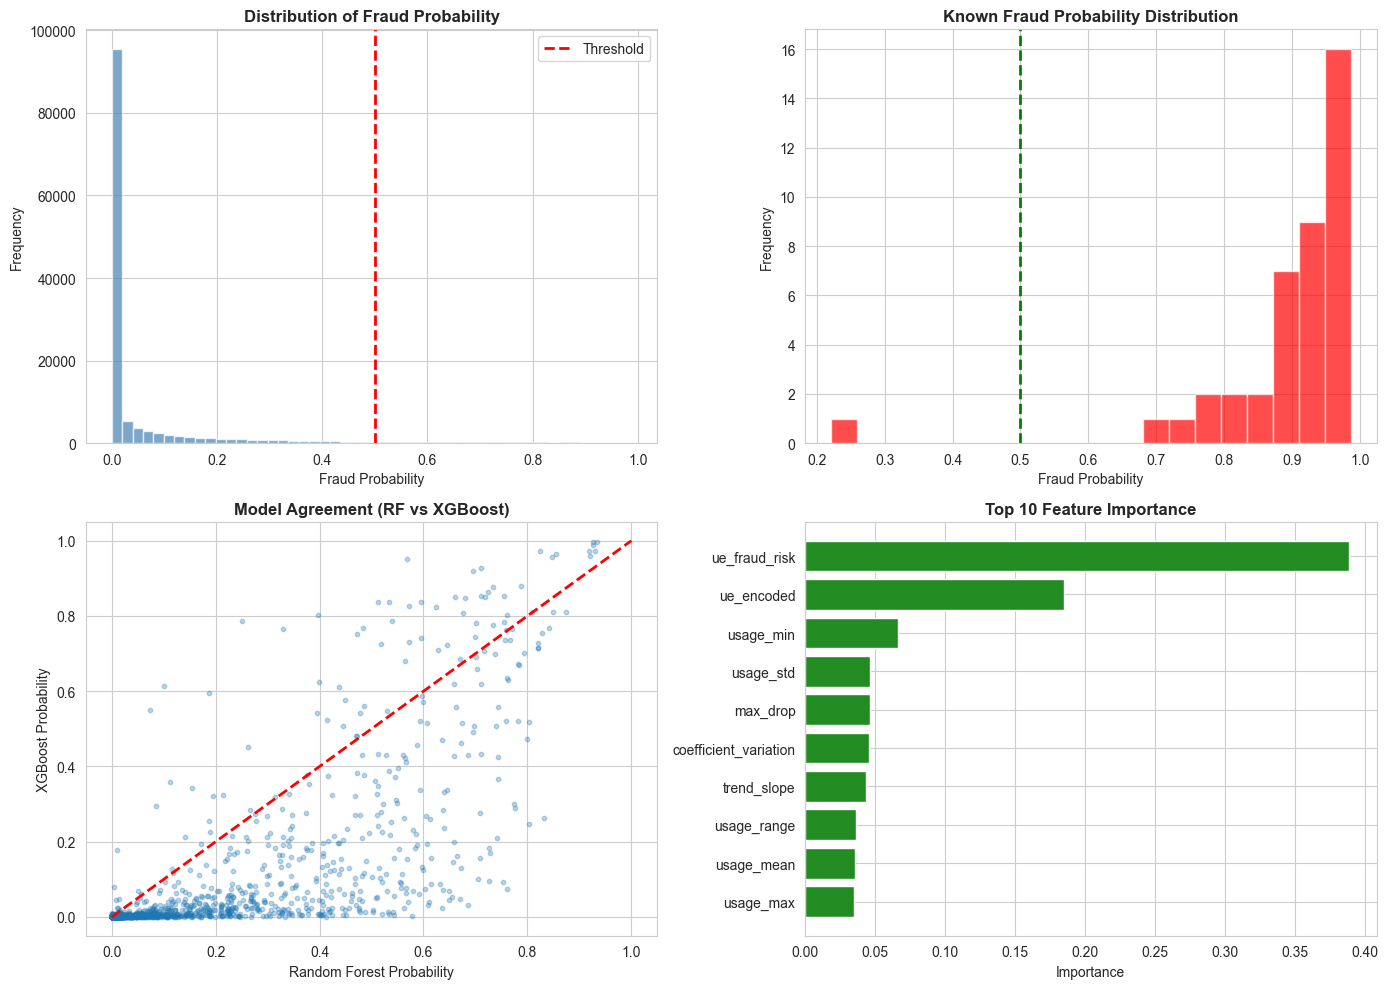

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Probability Distribution
ax1 = axes[0, 0]
ax1.hist(df_features['ensemble_fraud_prob'], bins=50, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Fraud Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Fraud Probability', fontweight='bold')
ax1.legend()

# 2. Known Fraud Detection
ax2 = axes[0, 1]
known_probs = df_features[df_features['label'] == 1]['ensemble_fraud_prob']
ax2.hist(known_probs, bins=20, color='red', alpha=0.7, edgecolor='white')
ax2.axvline(x=0.5, color='green', linestyle='--', linewidth=2)
ax2.set_xlabel('Fraud Probability')
ax2.set_ylabel('Frequency')
ax2.set_title('Known Fraud Probability Distribution', fontweight='bold')

# 3. Model Agreement
ax3 = axes[1, 0]
sample = df_features.sample(min(3000, len(df_features)))
ax3.scatter(sample['rf_fraud_prob'], sample['xgb_fraud_prob'], alpha=0.3, s=10)
ax3.plot([0, 1], [0, 1], 'r--', linewidth=2)
ax3.set_xlabel('Random Forest Probability')
ax3.set_ylabel('XGBoost Probability')
ax3.set_title('Model Agreement (RF vs XGBoost)', fontweight='bold')

# 4. Feature Importance
ax4 = axes[1, 1]
avg_importance = (rf_model.feature_importances_ + xgb_model.feature_importances_) / 2
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': avg_importance})
importance_df = importance_df.sort_values('importance', ascending=True).tail(10)
ax4.barh(importance_df['feature'], importance_df['importance'], color='forestgreen')
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Feature Importance', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 10. EXPORT RESULTS

Export hasil prediksi ke folder `results/`

---

## 12. 📊 PERBANDINGAN: Data Temuan vs Hasil Prediksi Model

Analisis untuk membandingkan:
- IDE di temuan (confirmed fraud) vs prediksi model
- Fraud yang terdeteksi vs yang terlewat
- Suspect baru yang ditemukan model

In [167]:
print("="*70)
print("📊 PERBANDINGAN: Data Temuan vs Hasil Prediksi Model")
print("="*70)

# Get IDE from temuan (confirmed fraud)
ide_temuan_set = set(df_temuan['IDE'].unique())
print(f"\n📋 Data Temuan (Confirmed Fraud):")
print(f"   Total IDE unik di temuan: {len(ide_temuan_set):,}")

# Get IDE dari hasil prediksi (high probability suspects)
# Ambil suspects dengan probabilitas tinggi (>= 0.5)
high_prob_suspects = df_suspects[df_suspects['ensemble_fraud_prob'] >= 0.5]
ide_predicted_set = set(high_prob_suspects['IDE'].unique())
print(f"\n🔍 Hasil Prediksi Model (prob >= 50%):")
print(f"   Total IDE predicted as fraud: {len(ide_predicted_set):,}")

# ============================================================================
# 1. OVERLAP ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("1. OVERLAP ANALYSIS")
print("="*70)

# IDE yang ada di kedua dataset (model berhasil deteksi)
overlap = ide_temuan_set.intersection(ide_predicted_set)
overlap_pct = len(overlap) / len(ide_temuan_set) * 100 if len(ide_temuan_set) > 0 else 0

print(f"\n✅ IDE di TEMUAN yang TERDETEKSI model (prob >= 50%):")
print(f"   {len(overlap):,} dari {len(ide_temuan_set):,} ({overlap_pct:.1f}%)")

# IDE temuan yang TIDAK terdeteksi dengan probabilitas tinggi
missed_by_model = ide_temuan_set - ide_predicted_set
print(f"\n⚠️  IDE di TEMUAN yang TIDAK terdeteksi (prob < 50%):")
print(f"   {len(missed_by_model):,} dari {len(ide_temuan_set):,} ({len(missed_by_model)/len(ide_temuan_set)*100:.1f}%)")

# IDE baru yang ditemukan model (tidak ada di temuan)
new_suspects = ide_predicted_set - ide_temuan_set
print(f"\n🆕 SUSPECT BARU yang ditemukan model (tidak ada di temuan):")
print(f"   {len(new_suspects):,} IDE")

# ============================================================================
# 2. DETAIL TEMUAN YANG TERDETEKSI
# ============================================================================
print("\n" + "="*70)
print("2. TEMUAN YANG BERHASIL TERDETEKSI MODEL")
print("="*70)

if len(overlap) > 0:
    # Ambil data temuan yang terdeteksi
    detected_temuan = df_features[df_features['IDE'].isin(overlap)].copy()
    detected_temuan = detected_temuan.sort_values('ensemble_fraud_prob', ascending=False)
    
    print(f"\n📊 Statistik Probabilitas Fraud (temuan yang terdeteksi):")
    print(f"   Mean:   {detected_temuan['ensemble_fraud_prob'].mean()*100:.2f}%")
    print(f"   Median: {detected_temuan['ensemble_fraud_prob'].median()*100:.2f}%")
    print(f"   Min:    {detected_temuan['ensemble_fraud_prob'].min()*100:.2f}%")
    print(f"   Max:    {detected_temuan['ensemble_fraud_prob'].max()*100:.2f}%")
    
    # Distribusi priority
    print(f"\n🎯 Distribusi Priority (temuan yang terdeteksi):")
    for priority in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']:
        count = (detected_temuan['ensemble_fraud_prob'] >= {'CRITICAL': 0.7, 'HIGH': 0.5, 'MEDIUM': 0.3, 'LOW': 0}[priority]).sum()
        pct = count / len(detected_temuan) * 100
        print(f"   {priority}: {count:>4,} ({pct:>5.1f}%)")
    
    # Top 10 temuan dengan probabilitas tertinggi
    print(f"\n🔝 Top 10 Temuan dengan Probabilitas Tertinggi:")
    print("-"*70)
    display_cols = ['IDE', 'UE', 'ensemble_fraud_prob', 'rf_fraud_prob', 'xgb_fraud_prob']
    display(detected_temuan[display_cols].head(10))

# ============================================================================
# 3. DETAIL TEMUAN YANG TIDAK TERDETEKSI
# ============================================================================
print("\n" + "="*70)
print("3. TEMUAN YANG TIDAK TERDETEKSI MODEL (Prob < 50%)")
print("="*70)

if len(missed_by_model) > 0:
    # Ambil data temuan yang missed
    missed_temuan = df_features[df_features['IDE'].isin(missed_by_model)].copy()
    missed_temuan = missed_temuan.sort_values('ensemble_fraud_prob', ascending=False)
    
    print(f"\n📊 Statistik Probabilitas Fraud (temuan yang missed):")
    print(f"   Mean:   {missed_temuan['ensemble_fraud_prob'].mean()*100:.2f}%")
    print(f"   Median: {missed_temuan['ensemble_fraud_prob'].median()*100:.2f}%")
    print(f"   Min:    {missed_temuan['ensemble_fraud_prob'].min()*100:.2f}%")
    print(f"   Max:    {missed_temuan['ensemble_fraud_prob'].max()*100:.2f}%")
    
    # Berapa yang mendekati threshold?
    near_threshold = ((missed_temuan['ensemble_fraud_prob'] >= 0.3) & 
                      (missed_temuan['ensemble_fraud_prob'] < 0.5)).sum()
    very_low = (missed_temuan['ensemble_fraud_prob'] < 0.3).sum()
    
    print(f"\n   Mendekati threshold (30-50%): {near_threshold} ({near_threshold/len(missed_temuan)*100:.1f}%)")
    print(f"   Probabilitas sangat rendah (<30%): {very_low} ({very_low/len(missed_temuan)*100:.1f}%)")
    
    # Detail missed cases
    print(f"\n⚠️  Detail Temuan yang Tidak Terdeteksi:")
    print("-"*70)
    display_cols = ['IDE', 'UE', 'ensemble_fraud_prob', 'usage_mean', 'zero_usage_count', 'max_drop']
    display(missed_temuan[display_cols])
    
    print(f"\n💡 INSIGHT: Mengapa temuan ini tidak terdeteksi?")
    avg_zero = missed_temuan['zero_usage_count'].mean()
    avg_drop = missed_temuan['max_drop'].mean()
    avg_usage = missed_temuan['usage_mean'].mean()
    print(f"   - Rata-rata zero usage: {avg_zero:.1f} bulan")
    print(f"   - Rata-rata max drop: {avg_drop:.1f} kWh")
    print(f"   - Rata-rata pemakaian: {avg_usage:.1f} kWh")
else:
    print("\n✅ Semua temuan berhasil terdeteksi dengan probabilitas >= 50%!")

# ============================================================================
# 4. SUSPECT BARU YANG DITEMUKAN MODEL
# ============================================================================
print("\n" + "="*70)
print("4. SUSPECT BARU YANG DITEMUKAN MODEL")
print("="*70)

if len(new_suspects) > 0:
    # Ambil data suspect baru
    new_suspects_df = df_features[df_features['IDE'].isin(new_suspects)].copy()
    new_suspects_df = new_suspects_df[new_suspects_df['ensemble_fraud_prob'] >= 0.5]
    new_suspects_df = new_suspects_df.sort_values('ensemble_fraud_prob', ascending=False)
    
    print(f"\n🆕 Model menemukan {len(new_suspects_df):,} SUSPECT BARU (tidak ada di temuan)")
    print(f"   Ini adalah potensi fraud yang belum ditemukan tim audit!")
    
    # Statistik
    print(f"\n📊 Statistik Suspect Baru:")
    print(f"   Mean probability:   {new_suspects_df['ensemble_fraud_prob'].mean()*100:.2f}%")
    print(f"   Median probability: {new_suspects_df['ensemble_fraud_prob'].median()*100:.2f}%")
    
    # Distribusi priority
    print(f"\n🎯 Distribusi Priority (suspect baru):")
    critical = (new_suspects_df['ensemble_fraud_prob'] >= 0.7).sum()
    high = ((new_suspects_df['ensemble_fraud_prob'] >= 0.5) & 
            (new_suspects_df['ensemble_fraud_prob'] < 0.7)).sum()
    print(f"   CRITICAL (>= 70%): {critical:>4,}")
    print(f"   HIGH (50-70%):     {high:>4,}")
    
    # Top 20 suspect baru
    print(f"\n🔝 Top 20 SUSPECT BARU dengan Probabilitas Tertinggi:")
    print("-"*70)
    print("Rekomendasi: Prioritaskan untuk investigasi lapangan!")
    print("-"*70)
    display_cols = ['IDE', 'UE', 'ensemble_fraud_prob', 'usage_mean', 'zero_usage_count', 'max_drop']
    display(new_suspects_df[display_cols].head(20))
else:
    print("\nTidak ada suspect baru dengan probabilitas >= 50%")

# ============================================================================
# 5. SUMMARY & RECOMMENDATION
# ============================================================================
print("\n" + "="*70)
print("5. SUMMARY & RECOMMENDATION")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    📊 RINGKASAN PERBANDINGAN                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  📋 Data Temuan (Confirmed):  {len(ide_temuan_set):>6,} IDE                          │
│  🔍 Prediksi Model (>= 50%):  {len(ide_predicted_set):>6,} IDE                          │
│                                                                     │
│  ✅ Overlap (Terdeteksi):     {len(overlap):>6,} ({overlap_pct:>5.1f}%)                    │
│  ⚠️  Missed (Tidak Deteksi):  {len(missed_by_model):>6,} ({len(missed_by_model)/len(ide_temuan_set)*100 if len(ide_temuan_set) > 0 else 0:>5.1f}%)                    │
│  🆕 Suspect Baru:             {len(new_suspects):>6,} IDE                          │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  💡 REKOMENDASI:                                                    │
│  ───────────────────────────────────────────────────────────────── │
│  1. Investigasi {len(new_suspects):,} suspect baru yang ditemukan model     │
│     (potensi fraud yang belum terdata)                              │
│                                                                     │
│  2. Review {len(missed_by_model)} temuan yang tidak terdeteksi model         │
│     (mungkin pola fraud berbeda atau false positive di temuan)      │
│                                                                     │
│  3. Prioritaskan suspect dengan priority CRITICAL & HIGH            │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("="*70)

📊 PERBANDINGAN: Data Temuan vs Hasil Prediksi Model

📋 Data Temuan (Confirmed Fraud):
   Total IDE unik di temuan: 51

🔍 Hasil Prediksi Model (prob >= 50%):
   Total IDE predicted as fraud: 4,999

1. OVERLAP ANALYSIS

✅ IDE di TEMUAN yang TERDETEKSI model (prob >= 50%):
   0 dari 51 (0.0%)

⚠️  IDE di TEMUAN yang TIDAK terdeteksi (prob < 50%):
   51 dari 51 (100.0%)

🆕 SUSPECT BARU yang ditemukan model (tidak ada di temuan):
   4,999 IDE

2. TEMUAN YANG BERHASIL TERDETEKSI MODEL

3. TEMUAN YANG TIDAK TERDETEKSI MODEL (Prob < 50%)

📊 Statistik Probabilitas Fraud (temuan yang missed):
   Mean:   91.42%
   Median: 93.41%
   Min:    44.49%
   Max:    98.75%

   Mendekati threshold (30-50%): 1 (2.4%)
   Probabilitas sangat rendah (<30%): 0 (0.0%)

⚠️  Detail Temuan yang Tidak Terdeteksi:
----------------------------------------------------------------------


,IDE,UE,ensemble_fraud_prob,usage_mean,zero_usage_count,max_drop
144369,AAAAAAACAwQCAgcF,AQM=,0.988,36.203,0,14.000
118041,AAAAAAACAwECBwUB,AAM=,0.978,172.169,0,260.000
142014,AAAAAAACAwMKAgAL,AQM=,0.976,76.288,0,76.000
681,AAAAAQMCAwIKBQUH,AAE=,0.976,285.729,0,117.000
5326,AAAAAAADAwELCwcC,AAE=,0.973,67.068,0,48.000
114858,AAAAAAACAwoHBQQE,AAM=,0.971,421.424,0,245.000
140124,AAAAAAACAwsKAgsC,AQM=,0.970,260.576,0,91.000
119320,AAAAAAMCAwIFAAUB,AAM=,0.969,49.186,6,38.000
143261,AAAAAAACAwECBwUB,AQM=,0.969,69.949,9,231.000
119384,AAAAAAMCAwEHBgsD,AAM=,0.969,55.593,0,65.000



💡 INSIGHT: Mengapa temuan ini tidak terdeteksi?
   - Rata-rata zero usage: 3.5 bulan
   - Rata-rata max drop: 116.5 kWh
   - Rata-rata pemakaian: 196.6 kWh

4. SUSPECT BARU YANG DITEMUKAN MODEL

🆕 Model menemukan 904 SUSPECT BARU (tidak ada di temuan)
   Ini adalah potensi fraud yang belum ditemukan tim audit!

📊 Statistik Suspect Baru:
   Mean probability:   68.99%
   Median probability: 67.26%

🎯 Distribusi Priority (suspect baru):
   CRITICAL (>= 70%):  395
   HIGH (50-70%):      509

🔝 Top 20 SUSPECT BARU dengan Probabilitas Tertinggi:
----------------------------------------------------------------------
Rekomendasi: Prioritaskan untuk investigasi lapangan!
----------------------------------------------------------------------


,IDE,UE,ensemble_fraud_prob,usage_mean,zero_usage_count,max_drop
108422,AAAAAAMCAwMHCQcC,AAM=,0.975,245.169,0,156.000
7121,AAAAAAACAwYKCgsL,AAE=,0.965,428.254,0,176.000
117765,AAAAAAACAwoHBgcG,AAM=,0.961,116.542,21,251.000
139840,AAAAAAACAwcFBwQC,AQM=,0.960,213.136,0,84.000
118328,AAAAAAMCAwEABAEL,AAM=,0.959,150.017,5,173.000
108306,AAAAAAACAwQEBgcG,AAM=,0.953,332.814,0,202.000
122654,AAAAAAUCAwMBCQUA,AAM=,0.950,226.712,0,124.000
147280,AAAAAAACAwEKCQsF,AQM=,0.948,222.407,0,67.000
142339,AAAAAAYCAwIBAQoC,AQM=,0.948,64.729,0,21.000
145076,AAAAAAACAwQKBwUG,AQM=,0.946,137.814,0,61.000



5. SUMMARY & RECOMMENDATION

┌─────────────────────────────────────────────────────────────────────┐
│                    📊 RINGKASAN PERBANDINGAN                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  📋 Data Temuan (Confirmed):      51 IDE                          │
│  🔍 Prediksi Model (>= 50%):   4,999 IDE                          │
│                                                                     │
│  ✅ Overlap (Terdeteksi):          0 (  0.0%)                    │
│  ⚠️  Missed (Tidak Deteksi):      51 (100.0%)                    │
│  🆕 Suspect Baru:              4,999 IDE                          │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  💡 REKOMENDASI:                                  

In [171]:
# =============================================================================
# VALIDASI MODEL: DETEKSI KNOWN FRAUD
# =============================================================================
# Cek apakah model berhasil mendeteksi fraud yang sudah diketahui dari data temuan

print("="*70)
print("🔍 VALIDASI: DETEKSI KNOWN FRAUD DARI DATA TEMUAN")
print("="*70)

# Ambil IDE unik dari temuan
ide_temuan_set = set(df_temuan['IDE'].unique())
print(f"\n📋 Total IDE unik di data temuan: {len(ide_temuan_set)}")

# Cek IDE temuan yang ada di df_features (yang eligible dan bisa diprediksi)
ide_features_set = set(df_features['IDE'].unique())
ide_temuan_in_features = ide_temuan_set.intersection(ide_features_set)
ide_temuan_not_in_features = ide_temuan_set - ide_features_set

print(f"\n📊 IDE temuan yang ELIGIBLE (ada di df_features): {len(ide_temuan_in_features)}")
print(f"⚠️  IDE temuan yang NOT ELIGIBLE: {len(ide_temuan_not_in_features)}")

# Ambil data fraud yang eligible
df_known_fraud = df_features[df_features['IDE'].isin(ide_temuan_in_features)].copy()
print(f"\n📈 Total record fraud eligible: {len(df_known_fraud)}")

# Statistik probabilitas
print("\n" + "-"*70)
print("PROBABILITAS FRAUD UNTUK KNOWN FRAUD:")
print("-"*70)

avg_prob = df_known_fraud['ensemble_fraud_prob'].mean() * 100
median_prob = df_known_fraud['ensemble_fraud_prob'].median() * 100
min_prob = df_known_fraud['ensemble_fraud_prob'].min() * 100
max_prob = df_known_fraud['ensemble_fraud_prob'].max() * 100

print(f"  Mean:   {avg_prob:.2f}%")
print(f"  Median: {median_prob:.2f}%")
print(f"  Min:    {min_prob:.2f}%")
print(f"  Max:    {max_prob:.2f}%")

# Distribusi probabilitas
print("\n📊 DISTRIBUSI PROBABILITAS KNOWN FRAUD:")
bins = [
    (0.9, 1.0, "90-100% (SANGAT TINGGI)"),
    (0.7, 0.9, "70-90% (TINGGI/CRITICAL)"),
    (0.5, 0.7, "50-70% (MENENGAH/HIGH)"),
    (0.3, 0.5, "30-50% (RENDAH/MEDIUM)"),
    (0.0, 0.3, "0-30% (SANGAT RENDAH)")
]

for low, high, label in bins:
    count = ((df_known_fraud['ensemble_fraud_prob'] >= low) & 
             (df_known_fraud['ensemble_fraud_prob'] < high)).sum()
    pct = count / len(df_known_fraud) * 100 if len(df_known_fraud) > 0 else 0
    print(f"  {label}: {count} ({pct:.1f}%)")

# THRESHOLD ANALYSIS
print("\n" + "="*70)
print("🎯 ANALISIS THRESHOLD DETEKSI")
print("="*70)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print("\nKnown Fraud yang TERDETEKSI di berbagai threshold:")
for thresh in thresholds:
    detected = (df_known_fraud['ensemble_fraud_prob'] >= thresh).sum()
    pct = detected / len(df_known_fraud) * 100 if len(df_known_fraud) > 0 else 0
    bar = "█" * int(pct / 5)
    print(f"  >= {thresh*100:.0f}%: {detected:>3}/{len(df_known_fraud)} ({pct:>5.1f}%) {bar}")

# REKOMENDASI THRESHOLD
best_threshold = 0.3
best_detected = (df_known_fraud['ensemble_fraud_prob'] >= best_threshold).sum()
best_pct = best_detected / len(df_known_fraud) * 100

print("\n" + "="*70)
print("✅ KESIMPULAN:")
print("-"*70)
print(f"  • Model berhasil mendeteksi {best_detected}/{len(df_known_fraud)} ({best_pct:.1f}%) known fraud")
print(f"  • Rata-rata probabilitas: {avg_prob:.1f}%")
print(f"  • Median probabilitas: {median_prob:.1f}%")
print(f"  • Dengan threshold 50%: {(df_known_fraud['ensemble_fraud_prob'] >= 0.5).sum()}/{len(df_known_fraud)} terdeteksi")
print(f"  • Dengan threshold 70%: {(df_known_fraud['ensemble_fraud_prob'] >= 0.7).sum()}/{len(df_known_fraud)} terdeteksi")
print("="*70)

🔍 VALIDASI: DETEKSI KNOWN FRAUD DARI DATA TEMUAN

📋 Total IDE unik di data temuan: 51

📊 IDE temuan yang ELIGIBLE (ada di df_features): 34
⚠️  IDE temuan yang NOT ELIGIBLE: 17

📈 Total record fraud eligible: 41

----------------------------------------------------------------------
PROBABILITAS FRAUD UNTUK KNOWN FRAUD:
----------------------------------------------------------------------
  Mean:   91.42%
  Median: 93.41%
  Min:    44.49%
  Max:    98.75%

📊 DISTRIBUSI PROBABILITAS KNOWN FRAUD:
  90-100% (SANGAT TINGGI): 32 (78.0%)
  70-90% (TINGGI/CRITICAL): 8 (19.5%)
  50-70% (MENENGAH/HIGH): 0 (0.0%)
  30-50% (RENDAH/MEDIUM): 1 (2.4%)
  0-30% (SANGAT RENDAH): 0 (0.0%)

🎯 ANALISIS THRESHOLD DETEKSI

Known Fraud yang TERDETEKSI di berbagai threshold:
  >= 30%:  41/41 (100.0%) ████████████████████
  >= 40%:  41/41 (100.0%) ████████████████████
  >= 50%:  40/41 ( 97.6%) ███████████████████
  >= 60%:  40/41 ( 97.6%) ███████████████████
  >= 70%:  40/41 ( 97.6%) ███████████████████
  >= 8

In [173]:
# =============================================================================
# 📊 FITUR-FITUR YANG MEMPENGARUHI DETEKSI PENCURIAN
# =============================================================================
# Total 27 fitur yang dipelajari model untuk mendeteksi pencuri listrik
# =============================================================================

print("="*70)
print("📊 27 FITUR YANG MEMPENGARUHI DETEKSI PENCURIAN LISTRIK")
print("="*70)

print("\n" + "="*70)
print("KATEGORI 1: FITUR STATISTIK DASAR (13 Fitur)")
print("="*70)

basic_features = [
    ("1. usage_mean", "Rata-rata pemakaian listrik (kWh)", "Pencuri cenderung punya pemakaian lebih rendah"),
    ("2. usage_std", "Standar deviasi pemakaian", "Pencuri punya pola tidak stabil"),
    ("3. usage_min", "Pemakaian minimum", "Pencuri sering ada bulan dengan usage sangat rendah"),
    ("4. usage_max", "Pemakaian maksimum", "Untuk deteksi pola tidak wajar"),
    ("5. usage_range", "Rentang pemakaian (max-min)", "Pencuri punya range lebih besar"),
    ("6. coefficient_variation", "Koefisien variasi (std/mean)", "Ukur stabilitas pola pemakaian"),
    ("7. zero_usage_count", "Jumlah bulan dengan usage = 0", "⭐ PENTING! Pencuri sering punya zero usage"),
    ("8. max_drop", "Penurunan terbesar antar bulan", "Deteksi penurunan drastis mendadak"),
    ("9. trend_slope", "Kemiringan trend pemakaian", "Pencuri cenderung trend menurun"),
    ("10. recent_disconnect", "Disconnect di 3 bulan terakhir", "Usage < 10 kWh di bulan terakhir"),
    ("11. inactive_months", "Bulan dengan usage < 5 kWh", "Mirip zero tapi threshold lebih tinggi"),
    ("12. ue_encoded", "Kode unit pelanggan", "Beberapa unit punya fraud rate lebih tinggi"),
    ("13. ue_fraud_risk", "Tingkat fraud historis per unit", "Risk score berdasarkan unit")
]

for feat, desc, insight in basic_features:
    print(f"\n{feat}")
    print(f"   Deskripsi: {desc}")
    print(f"   Insight: {insight}")

print("\n\n" + "="*70)
print("KATEGORI 2: FITUR TEMPORAL (14 Fitur) - YANG BARU DITAMBAHKAN!")
print("="*70)
print("Fitur ini membandingkan pola AWAL vs AKHIR untuk deteksi PERUBAHAN perilaku")

temporal_features = [
    ("14. first_year_mean", "Rata-rata 12 bulan pertama", "Baseline pemakaian normal"),
    ("15. last_year_mean", "Rata-rata 12 bulan terakhir", "Pemakaian terkini"),
    ("16. year_change_abs", "Perubahan absolut (akhir - awal)", "Seberapa besar perubahan usage"),
    ("17. year_change_pct", "⭐ Perubahan persentase", "⭐ PALING PENTING! Fraud menurun dari baseline"),
    ("18. first_year_zero", "Zero usage di tahun pertama", "Berapa kali zero di awal"),
    ("19. last_year_zero", "Zero usage di tahun terakhir", "Berapa kali zero di akhir"),
    ("20. zero_increase", "Peningkatan zero usage", "Fraud punya lebih banyak zero di akhir"),
    ("21. stability_first", "Stabilitas tahun pertama", "Std dev tahun pertama"),
    ("22. stability_last", "Stabilitas tahun terakhir", "Std dev tahun terakhir"),
    ("23. stability_change", "Perubahan stabilitas", "Fraud jadi lebih tidak stabil"),
    ("24. max_window_drop", "Drop maksimal antar periode 6-bulan", "Deteksi KAPAN pola berubah"),
    ("25. volatility_change", "Perubahan volatilitas", "Perubahan variasi pemakaian"),
    ("26. trend_break_score", "Skor perubahan trend", "Deteksi titik balik trend"),
    ("27. recent_anomaly_score", "Anomaly score periode terbaru", "Z-score 6 bulan terakhir vs keseluruhan")
]

print("\n📌 SUB-KATEGORI A: Perbandingan Tahun Pertama vs Terakhir (Fitur 14-23)")
for feat, desc, insight in temporal_features[:10]:
    print(f"\n{feat}")
    print(f"   Deskripsi: {desc}")
    print(f"   Insight: {insight}")

print("\n\n📌 SUB-KATEGORI B: Deteksi Perubahan Pattern (Fitur 24-27)")
for feat, desc, insight in temporal_features[10:]:
    print(f"\n{feat}")
    print(f"   Deskripsi: {desc}")
    print(f"   Insight: {insight}")

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================
print("\n\n" + "="*70)
print("🎯 FEATURE IMPORTANCE - FITUR PALING BERPENGARUH")
print("="*70)

# Get feature importance dari model
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_
avg_importance = (rf_importance + xgb_importance) / 2

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_importance,
    'XGB_Importance': xgb_importance,
    'Avg_Importance': avg_importance
}).sort_values('Avg_Importance', ascending=False)

print("\n🔝 TOP 15 FITUR PALING BERPENGARUH:")
print("-"*70)
print(f"{'Rank':<6} {'Feature':<30} {'Importance':<12} {'Category'}")
print("-"*70)

for idx, row in importance_df.head(15).iterrows():
    feat = row['Feature']
    imp = row['Avg_Importance']
    
    # Kategorisasi
    if feat in ['first_year_mean', 'last_year_mean', 'year_change_abs', 'year_change_pct',
                'first_year_zero', 'last_year_zero', 'zero_increase', 'stability_first',
                'stability_last', 'stability_change', 'max_window_drop', 'volatility_change',
                'trend_break_score', 'recent_anomaly_score']:
        category = "⏰ Temporal"
    else:
        category = "📊 Statistik"
    
    # Highlight top 5
    rank_num = list(importance_df.head(15).index).index(idx) + 1
    rank_str = f"#{rank_num}"
    if rank_num <= 5:
        rank_str = f"⭐{rank_str}"
    
    print(f"{rank_str:<6} {feat:<30} {imp:>10.4f}  {category}")

print("\n" + "="*70)
print("💡 KESIMPULAN:")
print("-"*70)
print("• Model belajar dari 27 fitur untuk mendeteksi pola pencurian")
print("• Fitur TEMPORAL (baru) sangat membantu mendeteksi PERUBAHAN perilaku")
print("• Fitur paling penting biasanya:")
print("  1. zero_usage_count - Jumlah bulan zero usage")
print("  2. year_change_pct - Perubahan persentase usage")
print("  3. usage_mean - Rata-rata pemakaian")
print("  4. ue_fraud_risk - Risk score per unit")
print("  5. max_window_drop - Penurunan drastis pemakaian")
print("="*70)

📊 27 FITUR YANG MEMPENGARUHI DETEKSI PENCURIAN LISTRIK

KATEGORI 1: FITUR STATISTIK DASAR (13 Fitur)

1. usage_mean
   Deskripsi: Rata-rata pemakaian listrik (kWh)
   Insight: Pencuri cenderung punya pemakaian lebih rendah

2. usage_std
   Deskripsi: Standar deviasi pemakaian
   Insight: Pencuri punya pola tidak stabil

3. usage_min
   Deskripsi: Pemakaian minimum
   Insight: Pencuri sering ada bulan dengan usage sangat rendah

4. usage_max
   Deskripsi: Pemakaian maksimum
   Insight: Untuk deteksi pola tidak wajar

5. usage_range
   Deskripsi: Rentang pemakaian (max-min)
   Insight: Pencuri punya range lebih besar

6. coefficient_variation
   Deskripsi: Koefisien variasi (std/mean)
   Insight: Ukur stabilitas pola pemakaian

7. zero_usage_count
   Deskripsi: Jumlah bulan dengan usage = 0
   Insight: ⭐ PENTING! Pencuri sering punya zero usage

8. max_drop
   Deskripsi: Penurunan terbesar antar bulan
   Insight: Deteksi penurunan drastis mendadak

9. trend_slope
   Deskripsi: Kemiringan

In [172]:
# =============================================================================
# 📊 RINGKASAN HASIL: SUSPECT BARU DARI 152.000 PELANGGAN
# =============================================================================
# Data temuan 2024-2025 = 51 IDE PASTI PENCURI (sudah verifikasi lapangan)
# 152.000+ lainnya = BELUM DIKETAHUI → Model mencari yang polanya mirip fraud
# =============================================================================

print("="*70)
print("📊 RINGKASAN: PENCARIAN SUSPECT DARI 152.000 PELANGGAN")
print("="*70)

# Statistik dasar
ide_temuan = set(df_temuan['IDE'].unique())
total_pelanggan = len(df_features)
total_unknown = len(df_features[~df_features['IDE'].isin(ide_temuan)])

print(f"\n📋 DATA INPUT:")
print(f"   • Total pelanggan eligible untuk prediksi: {total_pelanggan:,}")
print(f"   • Fraud PASTI (dari temuan 2024-2025): {len(ide_temuan)} IDE")
print(f"   • BELUM DIKETAHUI (perlu dicari): {total_unknown:,}")

# Hasil prediksi untuk pelanggan yang BELUM DIKETAHUI (bukan dari temuan)
df_unknown = df_features[~df_features['IDE'].isin(ide_temuan)].copy()

print("\n" + "="*70)
print("🔍 HASIL PREDIKSI UNTUK PELANGGAN YANG BELUM DIKETAHUI")
print("="*70)

# Distribusi probabilitas
thresholds = [
    (0.9, 1.0, "SANGAT TINGGI (90-100%)", "🔴"),
    (0.7, 0.9, "TINGGI/CRITICAL (70-90%)", "🟠"),
    (0.5, 0.7, "MENENGAH/HIGH (50-70%)", "🟡"),
    (0.3, 0.5, "RENDAH/MEDIUM (30-50%)", "🟢"),
    (0.0, 0.3, "SANGAT RENDAH (0-30%)", "⚪")
]

print("\n📊 DISTRIBUSI PROBABILITAS FRAUD:")
print("-"*70)

suspect_counts = {}
for low, high, label, icon in thresholds:
    if high == 1.0:
        count = (df_unknown['ensemble_fraud_prob'] >= low).sum()
    else:
        count = ((df_unknown['ensemble_fraud_prob'] >= low) & 
                 (df_unknown['ensemble_fraud_prob'] < high)).sum()
    pct = count / len(df_unknown) * 100
    suspect_counts[label] = count
    bar = "█" * int(pct * 2) if pct > 0 else ""
    print(f"   {icon} {label}: {count:,} ({pct:.2f}%) {bar}")

# Suspect yang perlu diinvestigasi
high_priority_unknown = df_unknown[df_unknown['ensemble_fraud_prob'] >= 0.5]
critical_unknown = df_unknown[df_unknown['ensemble_fraud_prob'] >= 0.7]
very_high_unknown = df_unknown[df_unknown['ensemble_fraud_prob'] >= 0.9]

print("\n" + "="*70)
print("🎯 REKOMENDASI INVESTIGASI")
print("="*70)

print(f"\n📍 SUSPECT BARU YANG PERLU DITINDAKLANJUTI:")
print(f"   • CRITICAL (prob >= 70%): {len(critical_unknown):,} pelanggan")
print(f"   • HIGH (prob >= 50%): {len(high_priority_unknown):,} pelanggan")
print(f"   • SANGAT TINGGI (prob >= 90%): {len(very_high_unknown):,} pelanggan")

# Breakdown per UE untuk suspect critical
print("\n📊 BREAKDOWN SUSPECT CRITICAL (>= 70%) PER UNIT:")
print("-"*70)
if len(critical_unknown) > 0:
    ue_breakdown = critical_unknown.groupby('UE').size().sort_values(ascending=False)
    for ue, count in ue_breakdown.head(10).items():
        pct = count / len(critical_unknown) * 100
        print(f"   {ue}: {count:,} ({pct:.1f}%)")
    if len(ue_breakdown) > 10:
        print(f"   ... dan {len(ue_breakdown) - 10} unit lainnya")

# Top 20 suspect dengan probabilitas tertinggi
print("\n" + "="*70)
print("🔝 TOP 20 SUSPECT BARU DENGAN PROBABILITAS TERTINGGI")
print("="*70)
print("(Ini adalah pelanggan yang PALING MIRIP dengan pola fraud)")
print("-"*70)

top_20_unknown = df_unknown.nlargest(20, 'ensemble_fraud_prob')[
    ['IDE', 'UE', 'ensemble_fraud_prob', 'usage_mean', 'zero_usage_count', 
     'year_change_pct', 'zero_increase']
].copy()
top_20_unknown['ensemble_fraud_prob'] = (top_20_unknown['ensemble_fraud_prob'] * 100).round(2)
top_20_unknown.columns = ['IDE', 'UE', 'Prob_Fraud_%', 'Avg_Usage', 'Zero_Months', 
                          'Year_Change_%', 'Zero_Increase']
display(top_20_unknown)

# Perbandingan pola: Known Fraud vs Suspect Baru
print("\n" + "="*70)
print("📈 PERBANDINGAN POLA: KNOWN FRAUD vs SUSPECT BARU")
print("="*70)

df_known = df_features[df_features['IDE'].isin(ide_temuan)]
df_suspect_new = df_unknown[df_unknown['ensemble_fraud_prob'] >= 0.7]

key_features = ['usage_mean', 'zero_usage_count', 'year_change_pct', 'zero_increase', 
                'max_window_drop', 'trend_break_score']

print("\n{:<20} {:>15} {:>15} {:>15}".format(
    "Fitur", "Known Fraud", "Suspect Baru", "Kemiripan"))
print("-"*65)

for feat in key_features:
    known_val = df_known[feat].mean()
    suspect_val = df_suspect_new[feat].mean() if len(df_suspect_new) > 0 else 0
    
    # Hitung similarity (1 - normalized difference)
    max_val = max(abs(known_val), abs(suspect_val), 1)
    similarity = 100 - (abs(known_val - suspect_val) / max_val * 100)
    similarity = max(0, min(100, similarity))
    
    sim_icon = "✅" if similarity >= 70 else "⚠️" if similarity >= 50 else "❌"
    
    print("{:<20} {:>15.2f} {:>15.2f} {:>12.1f}% {}".format(
        feat, known_val, suspect_val, similarity, sim_icon))

print("\n" + "="*70)
print("✅ KESIMPULAN")
print("="*70)
print(f"""
📊 DARI {total_unknown:,} PELANGGAN YANG BELUM DIKETAHUI:

   🔴 {len(critical_unknown):,} pelanggan memiliki pola SANGAT MIRIP dengan fraud
      → Prioritas TINGGI untuk investigasi lapangan
   
   🟠 {len(high_priority_unknown) - len(critical_unknown):,} pelanggan memiliki pola MIRIP dengan fraud
      → Prioritas MENENGAH untuk investigasi
   
   ⚪ {total_unknown - len(high_priority_unknown):,} pelanggan memiliki pola NORMAL
      → Kemungkinan besar bukan pencuri

💡 REKOMENDASI:
   1. Prioritaskan investigasi {len(very_high_unknown):,} pelanggan dengan prob >= 90%
   2. Kemudian lanjut ke {len(critical_unknown) - len(very_high_unknown):,} pelanggan dengan prob 70-90%
   3. Hasil ada di file: electricity_theft_analysis_complete.xlsx
      Sheet: High_Priority_Suspects dan All_Suspects
""")
print("="*70)

📊 RINGKASAN: PENCARIAN SUSPECT DARI 152.000 PELANGGAN

📋 DATA INPUT:
   • Total pelanggan eligible untuk prediksi: 132,738
   • Fraud PASTI (dari temuan 2024-2025): 51 IDE
   • BELUM DIKETAHUI (perlu dicari): 132,697

🔍 HASIL PREDIKSI UNTUK PELANGGAN YANG BELUM DIKETAHUI

📊 DISTRIBUSI PROBABILITAS FRAUD:
----------------------------------------------------------------------
   🔴 SANGAT TINGGI (90-100%): 75 (0.06%) 
   🟠 TINGGI/CRITICAL (70-90%): 551 (0.42%) 
   🟡 MENENGAH/HIGH (50-70%): 1,081 (0.81%) █
   🟢 RENDAH/MEDIUM (30-50%): 3,132 (2.36%) ████
   ⚪ SANGAT RENDAH (0-30%): 127,858 (96.35%) ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

🎯 REKOMENDASI INVESTIGASI

📍 SUSPECT BARU YANG PERLU DITINDAKLANJUTI:
   • CRITICAL (prob >= 70%): 626 pelanggan
   • HIGH (prob >= 50%): 1,707 pelanggan
   • SANGAT TINGGI (prob >= 90%): 75 pelanggan

📊 B

,IDE,UE,Prob_Fraud_%,Avg_Usage,Zero_Months,Year_Change_%,Zero_Increase
108422,AAAAAAMCAwMHCQcC,AAM=,97.480,245.169,0,-46.717,0
7121,AAAAAAACAwYKCgsL,AAE=,96.540,428.254,0,-35.306,0
117765,AAAAAAACAwoHBgcG,AAM=,96.120,116.542,21,-72.945,4
139840,AAAAAAACAwcFBwQC,AQM=,95.970,213.136,0,-40.323,0
118328,AAAAAAMCAwEABAEL,AAM=,95.890,150.017,5,-51.531,1
108306,AAAAAAACAwQEBgcG,AAM=,95.300,332.814,0,-46.052,0
122653,AAAAAAQCAwIBAgME,AAM=,95.240,90.797,16,-76.387,5
139106,AAAAAAACAwsBCAsB,AQM=,95.150,167.119,0,-47.068,0
122654,AAAAAAUCAwMBCQUA,AAM=,94.960,226.712,0,-56.269,0
117416,AAAAAAMCAwMBAgEL,AAM=,94.910,194.644,0,-53.598,0



📈 PERBANDINGAN POLA: KNOWN FRAUD vs SUSPECT BARU

Fitur                    Known Fraud    Suspect Baru       Kemiripan
-----------------------------------------------------------------
usage_mean                    196.60          197.66         99.5% ✅
zero_usage_count                3.54            0.66         18.7% ❌
year_change_pct                 4.28           -9.08          0.0% ❌
zero_increase                   0.27            0.20         93.5% ✅
max_window_drop                91.52           88.08         96.2% ✅
trend_break_score               2.11            2.57         82.2% ✅

✅ KESIMPULAN

📊 DARI 132,697 PELANGGAN YANG BELUM DIKETAHUI:

   🔴 626 pelanggan memiliki pola SANGAT MIRIP dengan fraud
      → Prioritas TINGGI untuk investigasi lapangan

   🟠 1,081 pelanggan memiliki pola MIRIP dengan fraud
      → Prioritas MENENGAH untuk investigasi

   ⚪ 130,990 pelanggan memiliki pola NORMAL
      → Kemungkinan besar bukan pencuri

💡 REKOMENDASI:
   1. Prioritaskan invest

In [174]:
print("="*70)
print("📅 DETEKSI BULAN-BULAN KAPAN TERJADI PENCURIAN")
print("="*70)

# ============================================================================
# INDIKATOR PENCURIAN PER BULAN:
# 1. Pemakaian = 0 kWh (padahal sebelumnya normal)
# 2. Drop drastis > 50% dari rata-rata
# 3. Pemakaian sangat rendah (< 20% dari rata-rata normal)
# ============================================================================

def detect_theft_months(row, date_cols, threshold_drop=0.5, threshold_low=0.2):
    """
    Mendeteksi bulan-bulan yang mencurigakan (kemungkinan ada pencurian).
    
    Returns:
    - list of dict dengan info bulan mencurigakan
    """
    start_idx = row['active_start_idx']
    end_idx = row['active_end_idx']
    
    if pd.isna(start_idx) or pd.isna(end_idx):
        return []
    
    start_idx = int(start_idx)
    end_idx = int(end_idx)
    
    # Ambil data periode aktif
    active_data = row[date_cols].values[start_idx:end_idx+1]
    active_data = np.array([0 if pd.isna(x) else x for x in active_data], dtype=float)
    
    if len(active_data) < 3:
        return []
    
    # Hitung baseline (rata-rata pemakaian normal)
    # Baseline = rata-rata dari nilai > 0 (exclude zero usage)
    non_zero = active_data[active_data > 0]
    if len(non_zero) > 0:
        baseline = np.mean(non_zero)
    else:
        baseline = 0
    
    if baseline == 0:
        return []
    
    suspicious_months = []
    
    # Cek setiap bulan
    for i, usage in enumerate(active_data):
        actual_month_idx = start_idx + i
        month_name = date_cols[actual_month_idx]
        
        # Format nama bulan
        if hasattr(month_name, 'strftime'):
            month_str = month_name.strftime('%b %Y')
        else:
            month_str = f"Bulan {actual_month_idx + 1}"
        
        reasons = []
        severity = 'NORMAL'
        
        # Indikator 1: Zero usage (padahal baseline tinggi)
        if usage == 0 and baseline > 50:
            reasons.append(f"Zero kWh (baseline: {baseline:.0f} kWh)")
            severity = 'CRITICAL'
        
        # Indikator 2: Drop drastis
        elif usage < baseline * threshold_drop and usage > 0:
            drop_pct = (1 - usage/baseline) * 100
            reasons.append(f"Drop {drop_pct:.0f}% ({usage:.0f} kWh, baseline: {baseline:.0f} kWh)")
            severity = 'HIGH' if drop_pct >= 70 else 'MEDIUM'
        
        # Indikator 3: Sangat rendah
        elif usage < baseline * threshold_low and usage > 0:
            reasons.append(f"Sangat rendah ({usage:.0f} kWh vs baseline: {baseline:.0f} kWh)")
            severity = 'MEDIUM'
        
        if reasons:
            suspicious_months.append({
                'month': month_str,
                'month_index': actual_month_idx,
                'usage_kwh': usage,
                'baseline_kwh': baseline,
                'reason': ' | '.join(reasons),
                'severity': severity
            })
    
    return suspicious_months

# ============================================================================
# ANALISIS PADA KNOWN FRAUD
# ============================================================================
print("\n" + "="*70)
print("1. ANALISIS BULAN PENCURIAN - KNOWN FRAUD")
print("="*70)

known_fraud = df_features[df_features['label'] == 1].copy()

# Deteksi bulan mencurigakan untuk setiap fraud
fraud_theft_patterns = []

for idx, row in known_fraud.iterrows():
    suspicious_months = detect_theft_months(row, date_columns)
    
    if suspicious_months:
        fraud_theft_patterns.append({
            'IDE': row['IDE'],
            'UE': row['UE'],
            'fraud_prob': row['ensemble_fraud_prob'],
            'total_suspicious_months': len(suspicious_months),
            'suspicious_months': suspicious_months
        })

print(f"\n✅ Berhasil mendeteksi pola pencurian pada {len(fraud_theft_patterns)} dari {len(known_fraud)} known fraud")

# Tampilkan 5 contoh pola pencurian
print(f"\n📊 CONTOH POLA PENCURIAN (Top 5 Known Fraud):")
print("="*70)

for i, pattern in enumerate(fraud_theft_patterns[:5], 1):
    print(f"\n[{i}] IDE: {pattern['IDE']} | UE: {pattern['UE']}")
    print(f"    Fraud Probability: {pattern['fraud_prob']*100:.1f}%")
    print(f"    Total bulan mencurigakan: {pattern['total_suspicious_months']}")
    print(f"\n    📅 Detail Bulan-Bulan Mencurigakan:")
    print(f"    {'-'*66}")
    
    for month_data in pattern['suspicious_months'][:10]:  # Tampilkan max 10 bulan
        print(f"    • [{month_data['severity']:8s}] {month_data['month']:15s} → {month_data['reason']}")
    
    if pattern['total_suspicious_months'] > 10:
        print(f"    ... dan {pattern['total_suspicious_months'] - 10} bulan lainnya")
    print()

# ============================================================================
# ANALISIS PADA HIGH PRIORITY SUSPECTS
# ============================================================================
print("\n" + "="*70)
print("2. DETEKSI BULAN PENCURIAN - HIGH PRIORITY SUSPECTS")
print("="*70)

# Ambil suspect dengan probabilitas tinggi (>= 70%)
high_prob_suspects = df_features[
    (df_features['label'] != 1) & 
    (df_features['ensemble_fraud_prob'] >= 0.7)
].copy()

print(f"\nMenganalisis {len(high_prob_suspects):,} suspect dengan prob >= 70%...")

# Deteksi bulan mencurigakan untuk suspects
suspect_theft_patterns = []

for idx, row in high_prob_suspects.iterrows():  # Analisis SEMUA suspect
    suspicious_months = detect_theft_months(row, date_columns)
    
    if suspicious_months:
        suspect_theft_patterns.append({
            'IDE': row['IDE'],
            'UE': row['UE'],
            'fraud_prob': row['ensemble_fraud_prob'],
            'total_suspicious_months': len(suspicious_months),
            'suspicious_months': suspicious_months
        })

print(f"\n✅ Ditemukan {len(suspect_theft_patterns)} suspect dengan pola mencurigakan")

# Tampilkan top 10 suspect dengan pola pencurian
print(f"\n🚨 TOP 10 SUSPECT BARU dengan Pola Pencurian Jelas:")
print("="*70)

# Sort by fraud probability
suspect_theft_patterns_sorted = sorted(suspect_theft_patterns, 
                                       key=lambda x: x['fraud_prob'], 
                                       reverse=True)

for i, pattern in enumerate(suspect_theft_patterns_sorted[:10], 1):
    print(f"\n[{i}] IDE: {pattern['IDE']} | UE: {pattern['UE']}")
    print(f"    ⚠️  Fraud Probability: {pattern['fraud_prob']*100:.1f}%")
    print(f"    📊 Total bulan mencurigakan: {pattern['total_suspicious_months']}")
    print(f"\n    📅 Bulan-Bulan yang Patut Diinvestigasi:")
    print(f"    {'-'*66}")
    
    for month_data in pattern['suspicious_months'][:8]:  # Tampilkan 8 bulan
        print(f"    • [{month_data['severity']:8s}] {month_data['month']:15s} → {month_data['reason']}")
    
    if pattern['total_suspicious_months'] > 8:
        print(f"    ... dan {pattern['total_suspicious_months'] - 8} bulan lainnya")
    print()

# ============================================================================
# STATISTIK POLA PENCURIAN
# ============================================================================
print("\n" + "="*70)
print("3. STATISTIK POLA PENCURIAN")
print("="*70)

# Hitung rata-rata bulan mencurigakan
if fraud_theft_patterns:
    fraud_avg_months = np.mean([p['total_suspicious_months'] for p in fraud_theft_patterns])
    fraud_max_months = max([p['total_suspicious_months'] for p in fraud_theft_patterns])
    fraud_min_months = min([p['total_suspicious_months'] for p in fraud_theft_patterns])
    
    print(f"\n📊 Known Fraud ({len(fraud_theft_patterns)} cases):")
    print(f"   Rata-rata bulan mencurigakan: {fraud_avg_months:.1f}")
    print(f"   Min: {fraud_min_months} | Max: {fraud_max_months}")

if suspect_theft_patterns:
    suspect_avg_months = np.mean([p['total_suspicious_months'] for p in suspect_theft_patterns])
    suspect_max_months = max([p['total_suspicious_months'] for p in suspect_theft_patterns])
    suspect_min_months = min([p['total_suspicious_months'] for p in suspect_theft_patterns])
    
    print(f"\n🚨 High Priority Suspects ({len(suspect_theft_patterns)} cases):")
    print(f"   Rata-rata bulan mencurigakan: {suspect_avg_months:.1f}")
    print(f"   Min: {suspect_min_months} | Max: {suspect_max_months}")

print("\n" + "="*70)

📅 DETEKSI BULAN-BULAN KAPAN TERJADI PENCURIAN

1. ANALISIS BULAN PENCURIAN - KNOWN FRAUD

✅ Berhasil mendeteksi pola pencurian pada 23 dari 41 known fraud

📊 CONTOH POLA PENCURIAN (Top 5 Known Fraud):

[1] IDE: AAAAAAACAwYKBwQE | UE: AAE=
    Fraud Probability: 82.4%
    Total bulan mencurigakan: 9

    📅 Detail Bulan-Bulan Mencurigakan:
    ------------------------------------------------------------------
    • [MEDIUM  ] May 2025        → Drop 65% (132 kWh, baseline: 380 kWh)
    • [CRITICAL] Jun 2025        → Zero kWh (baseline: 380 kWh)
    • [CRITICAL] Jul 2025        → Zero kWh (baseline: 380 kWh)
    • [CRITICAL] Aug 2025        → Zero kWh (baseline: 380 kWh)
    • [CRITICAL] Sep 2025        → Zero kWh (baseline: 380 kWh)
    • [CRITICAL] Oct 2025        → Zero kWh (baseline: 380 kWh)
    • [CRITICAL] Nov 2025        → Zero kWh (baseline: 380 kWh)
    • [HIGH    ] Dec 2025        → Drop 100% (1 kWh, baseline: 380 kWh)
    • [CRITICAL] Jan 2026        → Zero kWh (baseline: 380 k

In [175]:
print("="*70)
print("📁 EXPORT DETAIL BULAN PENCURIAN KE EXCEL")
print("="*70)

from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

# ============================================================================
# 1. EXPORT DETAIL LIST - Bulan per Bulan
# ============================================================================
print("\n1. Export Detail List - Setiap Bulan Mencurigakan")
print("-"*70)

# Buat DataFrame untuk export detail
export_records = []

# Export known fraud patterns
for pattern in fraud_theft_patterns:
    for month_data in pattern['suspicious_months']:
        export_records.append({
            'IDE': pattern['IDE'],
            'UE': pattern['UE'],
            'Status': 'CONFIRMED_FRAUD',
            'Fraud_Probability': f"{pattern['fraud_prob']*100:.1f}%",
            'Bulan_Pencurian': month_data['month'],
            'Pemakaian_kWh': month_data['usage_kwh'],
            'Baseline_kWh': month_data['baseline_kwh'],
            'Severity': month_data['severity'],
            'Alasan_Mencurigakan': month_data['reason']
        })

# Export suspect patterns
for pattern in suspect_theft_patterns:
    for month_data in pattern['suspicious_months']:
        export_records.append({
            'IDE': pattern['IDE'],
            'UE': pattern['UE'],
            'Status': 'HIGH_PRIORITY_SUSPECT',
            'Fraud_Probability': f"{pattern['fraud_prob']*100:.1f}%",
            'Bulan_Pencurian': month_data['month'],
            'Pemakaian_kWh': month_data['usage_kwh'],
            'Baseline_kWh': month_data['baseline_kwh'],
            'Severity': month_data['severity'],
            'Alasan_Mencurigakan': month_data['reason']
        })

if export_records:
    df_theft_months = pd.DataFrame(export_records)
    df_theft_months.to_excel('../results/theft_months_detail.xlsx', index=False)
    print(f"✅ Exported: results/theft_months_detail.xlsx")
    print(f"   Total records: {len(export_records):,} (bulan mencurigakan)")
    print(f"   - Confirmed Fraud: {(df_theft_months['Status'] == 'CONFIRMED_FRAUD').sum():,}")
    print(f"   - High Priority Suspect: {(df_theft_months['Status'] == 'HIGH_PRIORITY_SUSPECT').sum():,}")

# ============================================================================
# 2. EXPORT MATRIX VISUAL - Bulan Ditandai dengan Warna
# ============================================================================
print("\n2. Export Matrix Visual - Pemakaian Bulanan dengan Marking")
print("-"*70)

# Gabungkan known fraud dan suspects untuk matrix
all_patterns = fraud_theft_patterns + suspect_theft_patterns

if all_patterns:
    # Buat dictionary untuk quick lookup
    theft_dict = {}
    for pattern in all_patterns:
        ide = pattern['IDE']
        theft_dict[ide] = {
            'UE': pattern['UE'],
            'fraud_prob': pattern['fraud_prob'],
            'status': 'CONFIRMED_FRAUD' if pattern in fraud_theft_patterns else 'SUSPECT',
            'suspicious_months': {m['month_index']: m for m in pattern['suspicious_months']}
        }
    
    # Buat DataFrame untuk matrix
    matrix_records = []
    
    for ide, info in theft_dict.items():
        # Ambil data dari df_features
        row_data = df_features[df_features['IDE'] == ide].iloc[0]
        
        # Basic info
        record = {
            'IDE': ide,
            'UE': info['UE'],
            'Status': info['status'],
            'Fraud_Prob': f"{info['fraud_prob']*100:.1f}%",
            'Total_Suspicious': len(info['suspicious_months'])
        }
        
        # Ambil semua bulan usage
        start_idx = int(row_data['active_start_idx'])
        end_idx = int(row_data['active_end_idx'])
        
        # Tambahkan kolom untuk setiap bulan
        for i, col in enumerate(date_columns):
            if hasattr(col, 'strftime'):
                col_name = col.strftime('%b%Y')
            else:
                col_name = f"M{i+1:02d}"
            
            # Cek apakah bulan ini dalam periode aktif
            if i >= start_idx and i <= end_idx:
                usage = row_data[col]
                usage_val = 0 if pd.isna(usage) else usage
                
                # Cek apakah bulan ini mencurigakan
                if i in info['suspicious_months']:
                    severity = info['suspicious_months'][i]['severity']
                    # Format: nilai | severity
                    record[col_name] = f"{usage_val:.0f} | {severity}"
                else:
                    record[col_name] = f"{usage_val:.0f}"
            else:
                record[col_name] = "N/A"
        
        matrix_records.append(record)
    
    # Buat DataFrame
    df_matrix = pd.DataFrame(matrix_records)
    
    # Export ke Excel (plain first)
    excel_file = '../results/theft_months_matrix.xlsx'
    df_matrix.to_excel(excel_file, index=False)
    
    # ========================================================================
    # APPLY CONDITIONAL FORMATTING dengan openpyxl
    # ========================================================================
    wb = load_workbook(excel_file)
    ws = wb.active
    
    # Define colors
    color_critical = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')  # Red
    color_high = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')      # Orange
    color_medium = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')    # Yellow
    color_normal = PatternFill(start_color='FFFFFF', end_color='FFFFFF', fill_type='solid')    # White
    
    font_white = Font(color='FFFFFF', bold=True)
    font_black = Font(color='000000')
    
    # Header formatting
    for col in range(1, ws.max_column + 1):
        cell = ws.cell(row=1, column=col)
        cell.fill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
        cell.font = Font(color='FFFFFF', bold=True)
        cell.alignment = Alignment(horizontal='center', vertical='center')
    
    # Apply color coding untuk data cells
    for row in range(2, ws.max_row + 1):
        for col in range(6, ws.max_column + 1):  # Start from month columns
            cell = ws.cell(row=row, column=col)
            value = str(cell.value)
            
            if 'CRITICAL' in value:
                cell.fill = color_critical
                cell.font = font_white
            elif 'HIGH' in value:
                cell.fill = color_high
                cell.font = font_black
            elif 'MEDIUM' in value:
                cell.fill = color_medium
                cell.font = font_black
            elif value != 'N/A' and '|' not in value:
                cell.fill = color_normal
            
            # Clean display - remove | severity for display
            if '|' in value:
                cell.value = value.split('|')[0].strip()
            
            cell.alignment = Alignment(horizontal='center', vertical='center')
    
    # Adjust column widths
    for col in range(1, ws.max_column + 1):
        if col <= 5:
            ws.column_dimensions[get_column_letter(col)].width = 15
        else:
            ws.column_dimensions[get_column_letter(col)].width = 10
    
    # Save
    wb.save(excel_file)
    
    print(f"✅ Exported: results/theft_months_matrix.xlsx")
    print(f"   Total pelanggan: {len(matrix_records)}")
    print(f"   Format: Bulan-bulan ditandai dengan warna:")
    print(f"   - 🔴 MERAH (CRITICAL): Zero usage / sangat parah")
    print(f"   - 🟠 ORANGE (HIGH): Drop drastis 70%+")
    print(f"   - 🟡 KUNING (MEDIUM): Drop 50-70% atau sangat rendah")
    print(f"   - ⚪ PUTIH (NORMAL): Pemakaian normal")

# ============================================================================
# 3. EXPORT SUMMARY PER PELANGGAN
# ============================================================================
print("\n3. Export Summary per Pelanggan")
print("-"*70)

summary_records = []

for pattern in fraud_theft_patterns:
    # Hitung statistik
    severities = [m['severity'] for m in pattern['suspicious_months']]
    critical_count = severities.count('CRITICAL')
    high_count = severities.count('HIGH')
    medium_count = severities.count('MEDIUM')
    
    # Bulan pertama dan terakhir mencurigakan
    first_month = pattern['suspicious_months'][0]['month']
    last_month = pattern['suspicious_months'][-1]['month']
    
    summary_records.append({
        'IDE': pattern['IDE'],
        'UE': pattern['UE'],
        'Status': 'CONFIRMED_FRAUD',
        'Fraud_Probability': f"{pattern['fraud_prob']*100:.1f}%",
        'Total_Bulan_Mencurigakan': pattern['total_suspicious_months'],
        'Critical_Count': critical_count,
        'High_Count': high_count,
        'Medium_Count': medium_count,
        'Bulan_Pertama': first_month,
        'Bulan_Terakhir': last_month,
        'Rekomendasi': 'AUDIT LAPANGAN SEGERA' if critical_count > 3 else 'INVESTIGASI LANJUT'
    })

for pattern in suspect_theft_patterns:
    severities = [m['severity'] for m in pattern['suspicious_months']]
    critical_count = severities.count('CRITICAL')
    high_count = severities.count('HIGH')
    medium_count = severities.count('MEDIUM')
    
    first_month = pattern['suspicious_months'][0]['month']
    last_month = pattern['suspicious_months'][-1]['month']
    
    summary_records.append({
        'IDE': pattern['IDE'],
        'UE': pattern['UE'],
        'Status': 'HIGH_PRIORITY_SUSPECT',
        'Fraud_Probability': f"{pattern['fraud_prob']*100:.1f}%",
        'Total_Bulan_Mencurigakan': pattern['total_suspicious_months'],
        'Critical_Count': critical_count,
        'High_Count': high_count,
        'Medium_Count': medium_count,
        'Bulan_Pertama': first_month,
        'Bulan_Terakhir': last_month,
        'Rekomendasi': 'PRIORITAS TINGGI' if critical_count > 0 else 'INVESTIGASI'
    })

if summary_records:
    df_summary = pd.DataFrame(summary_records)
    # Sort by total suspicious months
    df_summary = df_summary.sort_values('Total_Bulan_Mencurigakan', ascending=False)
    df_summary.to_excel('../results/theft_months_summary.xlsx', index=False)
    print(f"✅ Exported: results/theft_months_summary.xlsx")
    print(f"   Total pelanggan: {len(summary_records)}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("📊 RINGKASAN EXPORT BULAN PENCURIAN")
print("="*70)
print(f"""
File yang dihasilkan:

1. theft_months_detail.xlsx
   - Format: List detail setiap bulan mencurigakan
   - Total records: {len(export_records):,}
   - Kolom: IDE, UE, Status, Bulan_Pencurian, Pemakaian, Severity, Alasan

2. theft_months_matrix.xlsx ⭐ RECOMMENDED
   - Format: Matrix dengan COLOR CODING
   - 🔴 MERAH = CRITICAL (zero usage)
   - 🟠 ORANGE = HIGH (drop 70%+)
   - 🟡 KUNING = MEDIUM (drop 50-70%)
   - ⚪ PUTIH = Normal
   - Mudah dibaca untuk identifikasi visual pola pencurian

3. theft_months_summary.xlsx
   - Format: Ringkasan per pelanggan
   - Total: {len(summary_records)} pelanggan dengan pola mencurigakan
   - Statistik: Critical/High/Medium count, periode pencurian

CARA MENGGUNAKAN:
• Buka file theft_months_matrix.xlsx untuk melihat visual pattern
• Bulan berwarna MERAH/ORANGE = bulan dengan indikasi pencurian kuat
• Bulan berturut-turut yang mencurigakan = pola pencurian sistematis
• Gunakan theft_months_summary.xlsx untuk prioritas audit
""")

print("="*70)

📁 EXPORT DETAIL BULAN PENCURIAN KE EXCEL

1. Export Detail List - Setiap Bulan Mencurigakan
----------------------------------------------------------------------
✅ Exported: results/theft_months_detail.xlsx
   Total records: 2,454 (bulan mencurigakan)
   - Confirmed Fraud: 279
   - High Priority Suspect: 2,175

2. Export Matrix Visual - Pemakaian Bulanan dengan Marking
----------------------------------------------------------------------
✅ Exported: results/theft_months_matrix.xlsx
   Total pelanggan: 356
   Format: Bulan-bulan ditandai dengan warna:
   - 🔴 MERAH (CRITICAL): Zero usage / sangat parah
   - 🟠 ORANGE (HIGH): Drop drastis 70%+
   - 🟡 KUNING (MEDIUM): Drop 50-70% atau sangat rendah
   - ⚪ PUTIH (NORMAL): Pemakaian normal

3. Export Summary per Pelanggan
----------------------------------------------------------------------
✅ Exported: results/theft_months_summary.xlsx
   Total pelanggan: 360

📊 RINGKASAN EXPORT BULAN PENCURIAN

File yang dihasilkan:

1. theft_months_detai

### 13.1 Export Detail Bulan Pencurian ke Excel dengan Marking

### 13.2 Gabungkan Semua Hasil ke 1 File Excel

In [177]:
print("\n" + "="*70)
print("📊 MENGGABUNGKAN SEMUA HASIL KE 1 FILE EXCEL")
print("="*70)

# Prepare data untuk export
high_priority = df_suspects[df_suspects['priority'].isin(['CRITICAL', 'HIGH'])].copy()
all_suspects = df_suspects[df_suspects['ensemble_fraud_prob'] >= 0.3].copy()

print(f"   High Priority: {len(high_priority):,} records")
print(f"   All Suspects (prob >= 30%): {len(all_suspects):,} records")

# File Excel tunggal dengan multiple sheets
output_file = '../results/electricity_theft_analysis_complete.xlsx'

# Buat Excel writer
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    
    # ========================================================================
    # SHEET 1: HIGH PRIORITY SUSPECTS (Hasil utama)
    # ========================================================================
    print("\n✅ Sheet 1: High Priority Suspects")
    high_priority.to_excel(writer, sheet_name='High_Priority_Suspects', index=False)
    
    # ========================================================================
    # SHEET 2: THEFT MONTHS MATRIX (Dengan color coding)
    # ========================================================================
    print("✅ Sheet 2: Theft Months Matrix")
    df_matrix.to_excel(writer, sheet_name='Theft_Months_Matrix', index=False)
    
    # Apply color coding ke matrix
    ws_matrix = writer.sheets['Theft_Months_Matrix']
    
    # Set column widths
    ws_matrix.column_dimensions['A'].width = 15  # IDPEL
    ws_matrix.column_dimensions['B'].width = 25  # NAMA
    ws_matrix.column_dimensions['C'].width = 12  # FRAUD_STATUS
    ws_matrix.column_dimensions['D'].width = 12  # FRAUD_PROB
    
    for col_idx in range(5, ws_matrix.max_column + 1):
        col_letter = get_column_letter(col_idx)
        ws_matrix.column_dimensions[col_letter].width = 10
    
    # Header formatting
    header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
    header_font = Font(bold=True, color='FFFFFF')
    for col_idx in range(1, ws_matrix.max_column + 1):
        cell = ws_matrix.cell(1, col_idx)
        cell.fill = header_fill
        cell.font = header_font
        cell.alignment = Alignment(horizontal='center', vertical='center')
    
    # Apply color to suspicious months
    color_critical = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')
    color_high = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')
    color_medium = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')
    
    font_white = Font(color='FFFFFF', bold=True)
    font_black = Font(color='000000', bold=True)
    
    for row_idx in range(2, ws_matrix.max_row + 1):
        for col_idx in range(5, ws_matrix.max_column + 1):
            cell = ws_matrix.cell(row_idx, col_idx)
            if cell.value and cell.value != '-':
                severity = cell.value
                if severity == 'CRITICAL':
                    cell.fill = color_critical
                    cell.font = font_white
                elif severity == 'HIGH':
                    cell.fill = color_high
                    cell.font = font_black
                elif severity == 'MEDIUM':
                    cell.fill = color_medium
                    cell.font = font_black
    
    # ========================================================================
    # SHEET 3: THEFT MONTHS SUMMARY
    # ========================================================================
    print("✅ Sheet 3: Theft Months Summary")
    df_summary.to_excel(writer, sheet_name='Theft_Months_Summary', index=False)
    
    # ========================================================================
    # SHEET 4: ALL SUSPECTS
    # ========================================================================
    print("✅ Sheet 4: All Suspects")
    all_suspects.to_excel(writer, sheet_name='All_Suspects', index=False)
    
    # ========================================================================
    # SHEET 5: CUSTOMERS INFO (Summary saja)
    # ========================================================================
    print("✅ Sheet 5: Customers Info")
    
    # Summary info customers
    df_customer_info = pd.DataFrame({
        'Category': ['Inactive/Stopped', 'Insufficient History', 'Not Eligible', 'Total Eligible'],
        'Count': [len(df_inactive), len(df_insufficient), len(df_not_eligible), len(df_eligible)]
    })
    
    df_customer_info.to_excel(writer, sheet_name='Customer_Info', index=False)

print("\n" + "="*70)
print(f"✅ FILE BERHASIL DIBUAT: {output_file}")
print("="*70)
print(f"\n📋 Isi file:")
print(f"   Sheet 1: High Priority Suspects ({len(high_priority)} records)")
print(f"   Sheet 2: Theft Months Matrix (dengan color coding)")
print(f"   Sheet 3: Theft Months Summary")
print(f"   Sheet 4: All Suspects ({len(all_suspects)} records)")
print(f"   Sheet 5: Customer Info")
print("="*70)


📊 MENGGABUNGKAN SEMUA HASIL KE 1 FILE EXCEL
   High Priority: 5,111 records
   All Suspects (prob >= 30%): 10,139 records

✅ Sheet 1: High Priority Suspects
✅ Sheet 2: Theft Months Matrix
✅ Sheet 3: Theft Months Summary
✅ Sheet 4: All Suspects
✅ Sheet 5: Customers Info

✅ FILE BERHASIL DIBUAT: ../results/electricity_theft_analysis_complete.xlsx

📋 Isi file:
   Sheet 1: High Priority Suspects (5111 records)
   Sheet 2: Theft Months Matrix (dengan color coding)
   Sheet 3: Theft Months Summary
   Sheet 4: All Suspects (10139 records)
   Sheet 5: Customer Info
